<a href="https://colab.research.google.com/github/TheFoolOrpheus/DAT-490-Capstone/blob/main/LACrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Put all libraries here, be sure to run this cell
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
import numpy as np
from statsmodels.stats.anova import anova_lm
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [ ]:
#This cell downloads the data. This first url download takes the LAPD data directly from the website, so you will not need to download
#the data onto your computer (if you want). You should only have to run this cell once, but if you leave the page for too long
#you will need to run this again.
url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"
lapd = pd.read_csv(url)
#The first "Browse" should be for the Census Zipcode data
uploadcensus1 = files.upload()
census = pd.read_csv(list(uploadcensus1.keys())[0])
# The second "Browse" should be for the Census Neighborhood Data (can be deleted if we all agree)
uploadcensus2 = files.upload()
censusneighborhood = pd.read_csv(list(uploadcensus2.keys())[0])
# The third "Browse" should be for the Simple Maps data
uploadsimplemaps = files.upload()
simplemaps = pd.read_csv(list(uploadsimplemaps.keys())[0])

KeyboardInterrupt: 

In [ ]:
#This cell does not need to be run
print("Crime Data:")
print(f"Shape: {lapd.shape}")
print(f"Columns: {list(lapd.columns)}")

print("\nCensus Data by Zip Code:")
print(f"Shape: {census.shape}")
print(f"Columns: {list(census.columns)}")

print("\nCensus Data by Neighborhood:")
print(f"Shape: {censusneighborhood.shape}")
print(f"Columns: {list(censusneighborhood.columns)}")

To prep the data for use in our exploratory data analysis, we need to clean the datasets. We'll start with our largest dataset, the LAPD crime dataset.

In [ ]:
#This cell does not need to be run
print("Basic Data Structure of Crime Data")
lapd.info()

print("\nMissing Values")
missingVals = lapd.isnull().sum().sort_values(ascending=False)
print(missingVals)

print("\nDate/Time Formatting Check")
print(f"Date range: {lapd['DATE OCC'].min()} to {lapd['DATE OCC'].max()}")
print(f"Unique Date Formats: {lapd['DATE OCC'].dtype}")

print("\nGeographic Coordinates Check")
print(f"Latitude Range: {lapd['LAT'].min()} to {lapd['LAT'].max()}")
print(f"Longitude Range: {lapd['LON'].min()} to {lapd['LON'].max()}")
print(f"No coordinates: {len(lapd[(lapd['LAT'] == 0 | (lapd['LON'] == 0))])}")

print("\nCrime Code Consistency Check")
crimeCodeMismatch = lapd[(lapd['Crm Cd'] != lapd['Crm Cd 1']) &
                         lapd['Crm Cd'].notna() &
                         lapd['Crm Cd 1'].notna()]
print(f"Crm Cd Mismatch Count: {len(crimeCodeMismatch)}")

print("\nVictim Demos Check")
print(lapd['Vict Age'].describe())
print(f"Missing Ages: {len(lapd[lapd['Vict Age'].isna()])}")
print(lapd['Vict Sex'].value_counts(dropna=False))
print(f"Missing Sex: {len(lapd[lapd['Vict Sex'].isna()])}")
print(lapd['Vict Descent'].value_counts(dropna=False))
print(f"Missing Descent: {len(lapd[lapd['Vict Descent'].isna()])}")

print("\nWeapon Check")
print(f"Missing Weapon Desc: {lapd['Weapon Desc'].isnull().sum()}")

print("\nPremise Check")
print(f"Missing Premise Desc: {lapd['Premis Desc'].isnull().sum()}")

print("\nMultiple Crimes Check")
print(f"Crm Cd 2 Count: {lapd['Crm Cd 2'].notna().sum()}")
print(f"Crm Cd 3 Count: {lapd['Crm Cd 3'].notna().sum()}")
print(f"Crm Cd 4 Count: {lapd['Crm Cd 4'].notna().sum()}")

Basic Data Structure of Crime Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Part 1-2        1004991 non-null  int64  
 8   Crm Cd          1004991 non-null  int64  
 9   Crm Cd Desc     1004991 non-null  object 
 10  Mocodes         853372 non-null   object 
 11  Vict Age        1004991 non-null  int64  
 12  Vict Sex        860347 non-null   object 
 13  Vict Descent    860335 non-null   object 
 14  Premis Cd       1004975 non-null  float64
 15  Premis Desc     1004403 non-null  object 
 16  W

In [ ]:
#This cell removes columns that we do not need, you must run it in order to clean up the data
removecolumns = ['Mocodes', 'Part 1-2', 'Status Desc']
lapd = lapd.drop(columns = removecolumns)
lapd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 25 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1004991 non-null  int64  
 1   Date Rptd       1004991 non-null  object 
 2   DATE OCC        1004991 non-null  object 
 3   TIME OCC        1004991 non-null  int64  
 4   AREA            1004991 non-null  int64  
 5   AREA NAME       1004991 non-null  object 
 6   Rpt Dist No     1004991 non-null  int64  
 7   Crm Cd          1004991 non-null  int64  
 8   Crm Cd Desc     1004991 non-null  object 
 9   Vict Age        1004991 non-null  int64  
 10  Vict Sex        860347 non-null   object 
 11  Vict Descent    860335 non-null   object 
 12  Premis Cd       1004975 non-null  float64
 13  Premis Desc     1004403 non-null  object 
 14  Weapon Used Cd  327247 non-null   float64
 15  Weapon Desc     327247 non-null   object 
 16  Status          1004990 non-null  ob

There are a large number of NaN victim sex and victim descents in the data set. Are these crimes "victimless" crimes, like property damage or theivery?

In [ ]:
#This cell does not need to be run
novictdemos = lapd[lapd['Vict Sex'].isnull() & lapd['Vict Descent'].isnull()]
print("\nVictimless Crimes:")
print(novictdemos['Crm Cd Desc'].value_counts())

print("Victim Ages for Victimless Crimes:")
print(novictdemos['Vict Age'].describe())


Victimless Crimes:
Crm Cd Desc
VEHICLE - STOLEN                                            114592
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              24334
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                    2330
VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)      2153
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD       768
BOAT - STOLEN                                                  150
BURGLARY                                                        67
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)         29
ROBBERY                                                         26
THEFT PLAIN - PETTY ($950 & UNDER)                              25
BURGLARY FROM VEHICLE                                           16
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                  15
DOCUMENT FORGERY / STOLEN FELONY                                13
TRESPASSING                                                     11
VANDALISM - MISDEAMEANOR ($399

The vast majority of these seem to be crimes that are "victimless", theivery, arson-- things that don't affect another person directly. But some of them are in fact things that affect another person directly. Which leads me to the discovery I made earlier-- does the reclassification of the crime in Crm Cd 1 somehow have to do with whether or not the crime should be considered "victimless"? Crm Cd Desc seems to be related to Crm Cd, which is, I believe, the details given to the police when the crime is called in. Crm Cd 1 is what the police determine after an investigation and they reclassify the crime. "BATTERY - SIMPLE ASSAULT" is something that I believe needs to be done on another person... But... if this crime were of a sexual nature, maybe the victim declined the police's help, or declined to be a part of the investigation? In which case, the police might not have been able to get the data they needed? If that's the case... Is it possible then that the police do not have a code for "could not recieve data"? There are only 25 cases of these strange types where it's clearly got a victim but there's no victim data. It may just be because of privacy or because the victim chose not to comply.

In [ ]:
#This cell does not need to be run
print("Weapons Data Analysis")
print(f"Missing Weapon Desc: {lapd['Weapon Desc'].isnull().sum():,} ({lapd['Weapon Desc'].isnull().sum()/len(lapd)*100:.1f}%)")

has_weapon = lapd[lapd['Weapon Desc'].notna()]
no_weapon = lapd[lapd['Weapon Desc'].isnull()]

print(f"\nRecords with weapon data: {len(has_weapon):,}")
print(f"Records without weapon data: {len(no_weapon):,}")

print("\nTop Crimes Types With Weapons:")
print(has_weapon['Crm Cd Desc'].value_counts().head(10))

print("\nTop Crimes Types Without Weapons:")
print(no_weapon['Crm Cd Desc'].value_counts().head(10))

Weapons Data Analysis
Missing Weapon Desc: 677,744 (67.4%)

Records with weapon data: 327,247
Records without weapon data: 677,744

Top Crimes Types With Weapons:
Crm Cd Desc
BATTERY - SIMPLE ASSAULT                                   74838
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             53522
INTIMATE PARTNER - SIMPLE ASSAULT                          46605
ROBBERY                                                    32306
CRIMINAL THREATS - NO WEAPON DISPLAYED                     19199
BRANDISH WEAPON                                            14532
INTIMATE PARTNER - AGGRAVATED ASSAULT                      12656
BURGLARY                                                    7623
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     6049
ATTEMPTED ROBBERY                                           4838
Name: count, dtype: int64

Top Crimes Types Without Weapons:
Crm Cd Desc
VEHICLE - STOLEN                                            115136
THEFT OF IDENTITY                  

I think this dataset is clean. Taking a close look at the data leads me to believe that there are places where things can be a bit fishy but it's definitely stuff that can be explained with some thought. I will add in my exploratory analysis of the crime codes and hopefully that will make this into a through investigation of this particular data set. I am going to move on now to the zip code census data.

In [ ]:
#This cell does not need to be run
print(f"Original Dataset Shape: {census.shape}")
print(f"Original Dataset Columns: {list(census.columns)}")
census.info()

print("\nMissing Values")
missingVals = census.isnull().sum().sort_values(ascending=False)
print(missingVals)

Original Dataset Shape: (319, 7)
Original Dataset Columns: ['Zip Code', 'Total Population', 'Median Age', 'Total Males', 'Total Females', 'Total Households', 'Average Household Size']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Zip Code                319 non-null    int64  
 1   Total Population        319 non-null    object 
 2   Median Age              319 non-null    float64
 3   Total Males             319 non-null    object 
 4   Total Females           319 non-null    object 
 5   Total Households        319 non-null    object 
 6   Average Household Size  319 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 17.6+ KB

Missing Values
Zip Code                  0
Total Population          0
Median Age                0
Total Males               0
Total Females             0
Total Households

Hmm. Weird. Okay, but... having no missing data says to me that it was either precleaned or aggregated in some way. I need to take a look at some of this data.

In [ ]:
#This cell does not need to be run
census.head(10)

,Zip Code,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size
0,91371,1,73.5,0,1,1,1.00
1,90001,"57,110",26.6,"28,468","28,642","12,971",4.40
2,90002,"51,223",25.5,"24,876","26,347","11,731",4.36
3,90003,"66,266",26.3,"32,631","33,635","15,642",4.22
4,90004,"62,180",34.8,"31,302","30,878","22,547",2.73
5,90005,"37,681",33.9,"19,299","18,382","15,044",2.50
6,90006,"59,185",32.4,"30,254","28,931","18,617",3.13
7,90007,"40,920",24.0,"20,915","20,005","11,944",3.00
8,90008,"32,327",39.7,"14,477","17,850","13,841",2.33
9,90010,"3,800",37.8,"1,874","1,926","2,014",1.87


I don't think this needs any prep... It is aggregate data based on what I'm looking at here. I am slightly confused by the 91371 zipcode but I suppose I can't argue with the data.

In [ ]:
#This cell does not need to be run
print(f"Original Dataset Shape: {censusneighborhood.shape}")
print(f"Original Dataset Columns: {list(censusneighborhood.columns)}")
censusneighborhood.info()

print("\nMissing Values")
missingVals = censusneighborhood.isnull().sum().sort_values(ascending=False)
print(missingVals)

Original Dataset Shape: (97, 13)
Original Dataset Columns: ['NC_Name', 'Total Population', 'White_pop', 'Black_pop', 'Ameri_es_pop', 'Asian_pop', 'Hawn_pi_pop', 'Hispanic_pop', 'Other_pop', 'Multi_pop', 'In_Poverty', 'Owner_occ', 'Renter_occ']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NC_Name           97 non-null     object 
 1   Total Population  97 non-null     object 
 2   White_pop         97 non-null     object 
 3   Black_pop         97 non-null     object 
 4   Ameri_es_pop      97 non-null     float64
 5   Asian_pop         97 non-null     object 
 6   Hawn_pi_pop       97 non-null     float64
 7   Hispanic_pop      0 non-null      float64
 8   Other_pop         97 non-null     float64
 9   Multi_pop         97 non-null     object 
 10  In_Poverty        97 non-null     object 
 11  Owner_occ         97 non-null     obj

Hispanic population is... empty? That's interesting. I don't see a reason to keep it if it's completely empty. We should just remove it and move forward.

In [ ]:
#Technically we run this cell **if** we are still using the neighborhood data. Otherwise, ignore.
cen_neigh = censusneighborhood.drop('Hispanic_pop', axis = 1)
cen_neigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NC_Name           97 non-null     object 
 1   Total Population  97 non-null     object 
 2   White_pop         97 non-null     object 
 3   Black_pop         97 non-null     object 
 4   Ameri_es_pop      97 non-null     float64
 5   Asian_pop         97 non-null     object 
 6   Hawn_pi_pop       97 non-null     float64
 7   Other_pop         97 non-null     float64
 8   Multi_pop         97 non-null     object 
 9   In_Poverty        97 non-null     object 
 10  Owner_occ         97 non-null     object 
 11  Renter_occ        97 non-null     object 
dtypes: float64(3), object(9)
memory usage: 9.2+ KB


In [ ]:
cen_neigh.head(10)

,NC_Name,Total Population,White_pop,Black_pop,Ameri_es_pop,Asian_pop,Hawn_pi_pop,Other_pop,Multi_pop,In_Poverty,Owner_occ,Renter_occ
0,ARLETA NC,"34,932.84","2,882.67",409.67,67.64,"4,061.31",34.96,37.58,245.05,"34,700.56","5,590.27","2,159.94"
1,ARROYO SECO NC,"21,711.47","4,640.35",782.76,89.51,"3,215.37",25.38,66.98,263.12,"21,582.85","4,138.14","3,235.61"
2,ATWATER VILLAGE NC,"11,385.4","3,450.7",127.8,0.15,"2,379.08",71.85,0.37,252.76,"11,345.53","1,877.3","2,902.89"
3,BEL AIR-BEVERLY CREST NC,"26,789.14","22,024.61",349.63,0.02,"1,787.79",0.01,156.92,946.28,"26,623.97","8,939.21","1,943.18"
4,BOYLE HEIGHTS NC,"81,900.56","1,562.2",640.97,63.63,"2,266.59",73.99,90.30,98.5,"81,144.31","4,743.28","16,001.77"
5,CANOGA PARK NC,"47,610.41","9,635.07","1,552.18",195.64,"5,932.33",69.39,61.12,605.86,"47,127.9","5,264.73","8,970.22"
6,CENTRAL ALAMEDA NC,"28,249.27",117.69,"2,400.73",37.97,259.14,22.77,48.07,100.08,"28,100.25","1,912.16","4,389.37"
7,CENTRAL HOLLYWOOD NC,"19,861.33","8,700.96","1,097.36",8.57,"1,179.26",81.56,13.65,567.42,"19,808.73",679.64,"9,033.08"
8,CENTRAL SAN PEDRO NC,"30,504.32","5,667.14","2,660.12",110.26,810.8,337.86,51.09,828.38,"30,216.99","1,966.03","8,445.43"
9,CHATSWORTH NC,"39,816.55","18,689.38","1,606.47",64.16,"7,239.56",20.55,83.92,"1,348.13","39,187.7","9,160.98","4,603.02"


That should do it for cleaning the data. I think. The data is now prepped to go! The *correct* data sets are:
- lapd
- census
- cen_neigh

Please use these going forward in your data exploration.

In [ ]:
#This cell does not need to be run
import matplotlib.pyplot as plt

hourly = lapd["HOUR"].value_counts().sort_index()

plt.figure(figsize=(10,5))
hourly.plot(kind="bar", color="dodgerblue")
plt.title("Crime Distribution by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.show()

KeyError: 'HOUR'

By distributing crime by the hour it reveals that crime is the lowest at around 3-6 am and the spike at noon shows that it is by far the most popular time for crime to occur. Additionally, the afternoon and mainly the evening have the highest average count. While the average is still high, crime steadily decreases from 6pm until 5am where the number of crimes turn to increase. Resource allocation should be strengthened towards the afternoon and evening hours.

/tmp/ipython-input-2341338683.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lapd["DATE OCC"] = pd.to_datetime(lapd["DATE OCC"], errors="coerce")


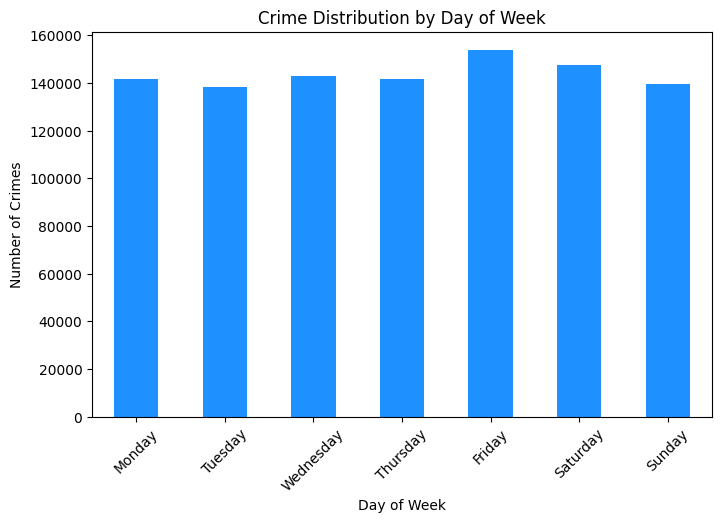

In [ ]:
#This cell does not need to be run
lapd["DATE OCC"] = pd.to_datetime(lapd["DATE OCC"], errors="coerce")
lapd["DAY_OF_WEEK"] = lapd["DATE OCC"].dt.day_name()
days_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
daily = lapd["DAY_OF_WEEK"].value_counts().reindex(days_order)

plt.figure(figsize=(8,5))
daily.plot(kind="bar", color="dodgerblue")
plt.title("Crime Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()


Plotting crimes by day of the week show a fairly even distribution of crime. The weekend has slightly a higher count compared to the weekdays, the main focus being Friday. Otherwise, the differences in results are fairly negligible. However, it would be most beneficial for resource distribution and deployment to be favored towards Friday and the res of the weekend.

In [ ]:
#This cell does not need to be run
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

lapd['DATE OCC'] = pd.to_datetime(lapd['DATE OCC'])
lapd['DAY_OF_WEEK'] = lapd['DATE OCC'].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
lapd['DAY_OF_WEEK'] = pd.Categorical(lapd['DAY_OF_WEEK'], categories=day_order, ordered=True)
heatmap_data = lapd.groupby(['DAY_OF_WEEK','HOUR']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index="DAY_OF_WEEK", columns="HOUR", values="count")
blue_cmap = LinearSegmentedColormap.from_list("blue_gradient", ["dodgerblue", "navy"])

plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_pivot,
    cmap=blue_cmap,
    linewidths=.5
)
plt.title("Crime Frequency by Hour and Day of Week", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


We can look at the correlation between hours of the day and days of the week via heatmap. It shows that noon consistently brings in the most crime throughout the day, and evenings showing a darker color than mornings. It once again shows the slight increase in crime on Fridays, but the hours and days to be repetitive and predictable throughout the week. This reassures the additional deployment to be favored in the afternoon and evenings on the weekend.

In [ ]:
#This cell does not need to be run
lapd["MONTH"] = lapd["DATE OCC"].dt.month_name()

months_order = ["January","February","March","April","May","June",
                "July","August","September","October","November","December"]
monthly = lapd["MONTH"].value_counts().reindex(months_order)

plt.figure(figsize=(12,5))
monthly.plot(kind="bar", color="dodgerblue")
plt.title("Crime Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

Sorting crime by month showcases a slight decline in crime throughout the year with the highest recording being in January. The late winter and summer months record a higher average than others. It would be most beneficial to allocate more resources and distribute deployment to those months

The crime analysis starts with the overall crime type distribution.

In [ ]:
#This cell does not need to be run
print("Crime Type Distribution")
crimecount = lapd["Crm Cd Desc"].value_counts()
print(f"Unique Crime Types: {len(crimecount)}")
print("\nTop 10 Crime Types")
print(crimecount.head(10))

Crime Type Distribution
Unique Crime Types: 140

Top 10 Crime Types
Crm Cd Desc
VEHICLE - STOLEN                                           115190
BATTERY - SIMPLE ASSAULT                                    74839
BURGLARY FROM VEHICLE                                       63517
THEFT OF IDENTITY                                           62537
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     61092
BURGLARY                                                    57871
THEFT PLAIN - PETTY ($950 & UNDER)                          53717
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              53525
INTIMATE PARTNER - SIMPLE ASSAULT                           46712
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             41314
Name: count, dtype: int64


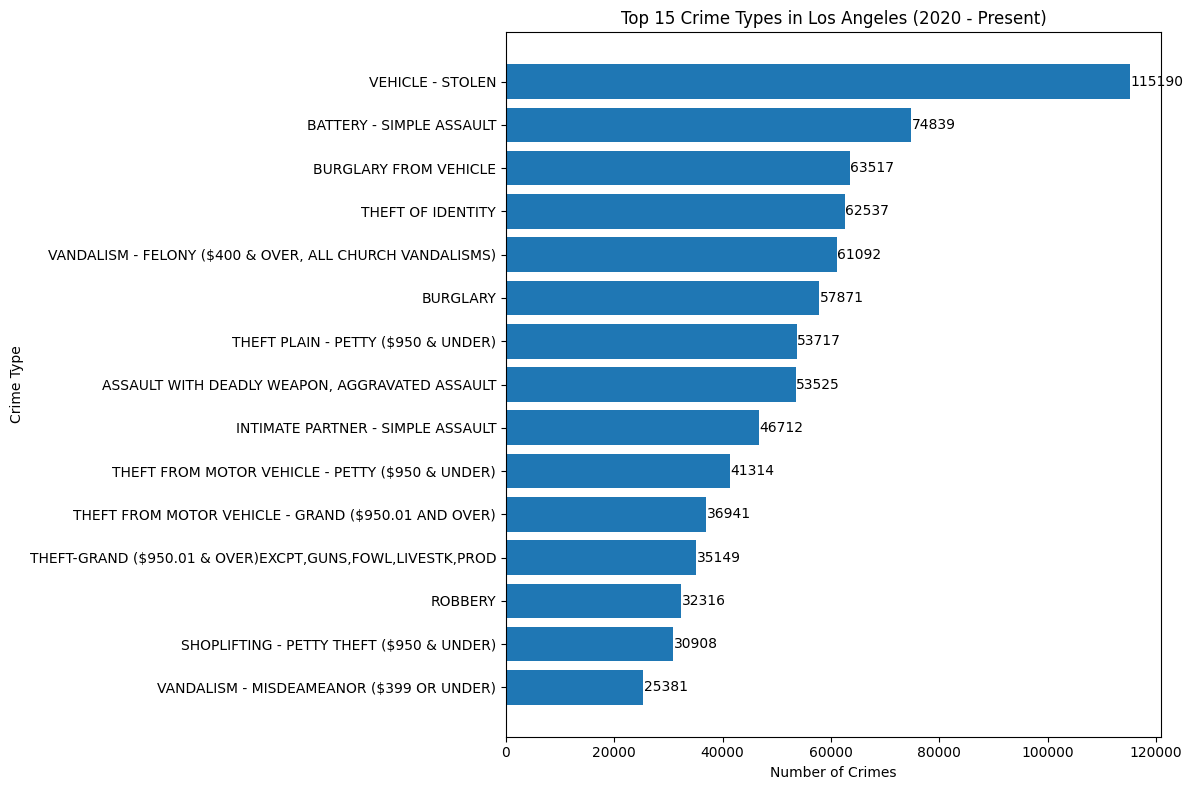

In [ ]:
#This cell does not need to be run
plt.style.use("default")
sns.color_palette("mako", as_cmap=True)

plt.figure(figsize=(12,8))
crimes15 = lapd['Crm Cd Desc'].value_counts().head(15)

plt.barh(range(len(crimes15)), crimes15.values)
plt.yticks(range(len(crimes15)), crimes15.index)
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.title("Top 15 Crime Types in Los Angeles (2020 - Present)")
plt.gca().invert_yaxis()

for i,v in enumerate(crimes15.values):
  plt.text(v + 100, i, f'{v:}', va='center')

plt.tight_layout()

plt.show()

Multi-crime incidents... I **think** would be an interesting look for the next part of the crime analysis?

Single Crime Count: 935,831
Multi Crime Count: 66,846
Triple Crime Count: 2,250
Quad Crime Count: 64


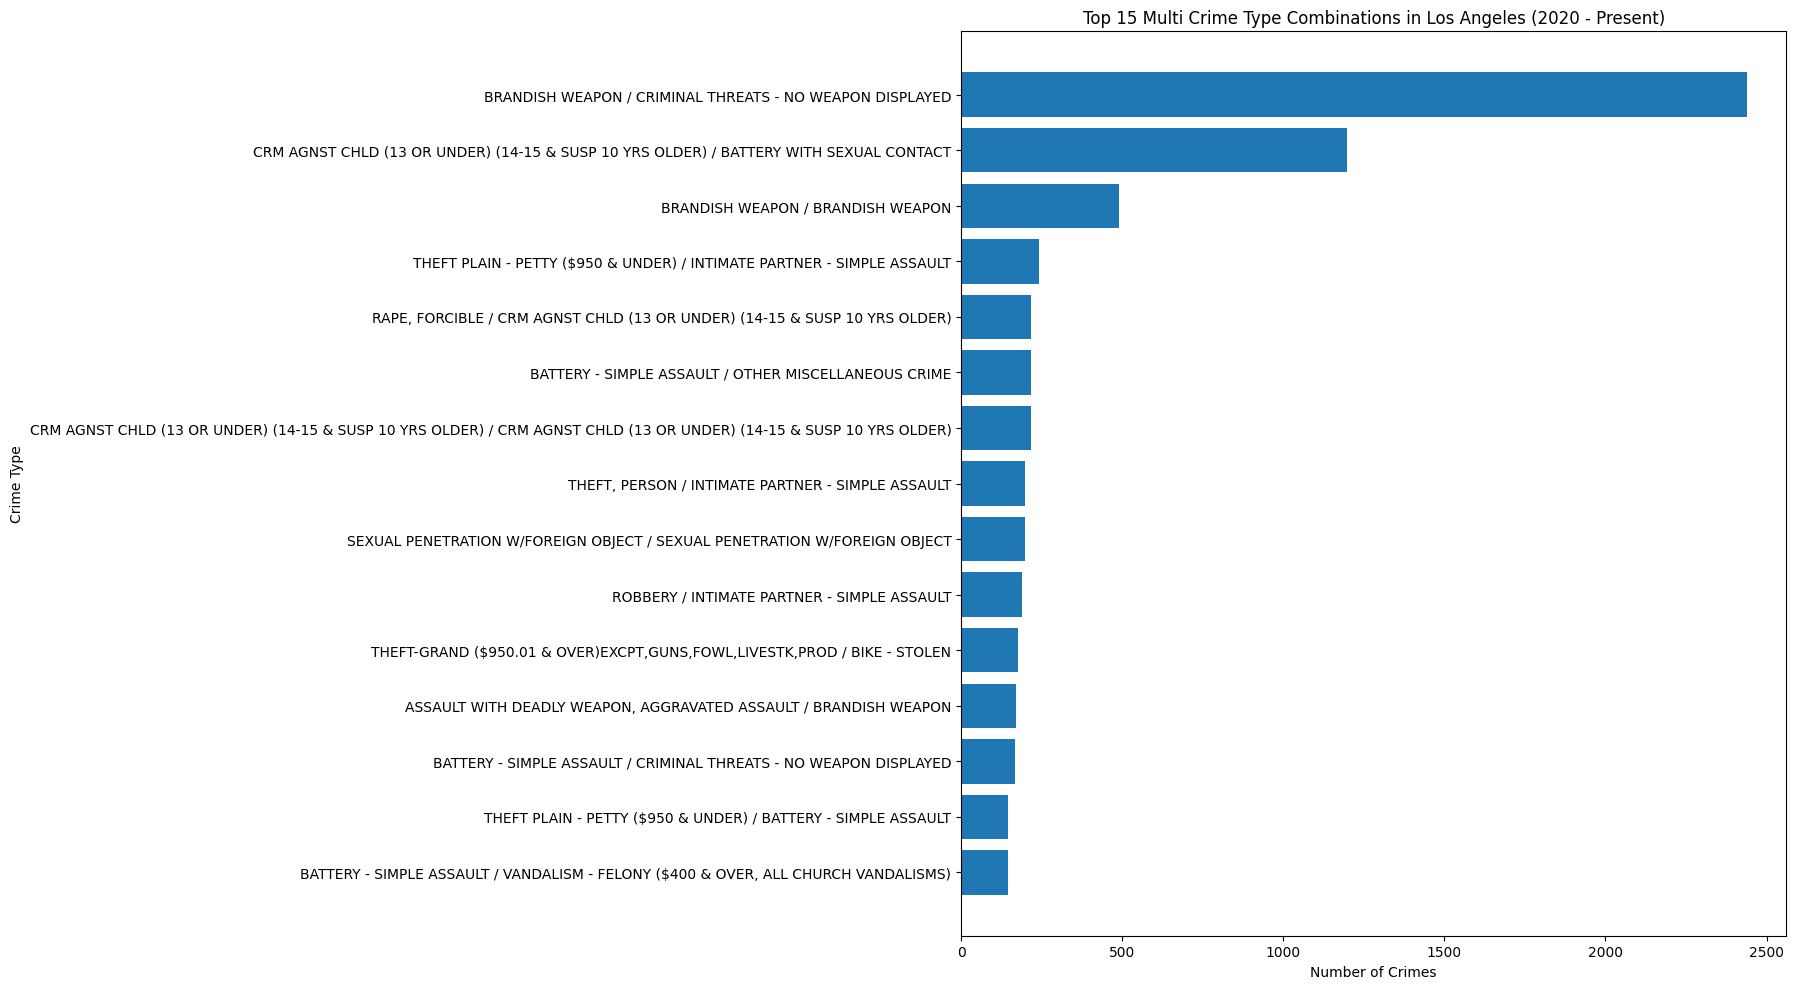

In [ ]:
#This cell does not need to be run
singlecrimes = lapd[lapd['Crm Cd 2'].isnull() & lapd['Crm Cd 3'].isnull() & lapd['Crm Cd 4'].isnull()]
multicrimes = lapd[~lapd['Crm Cd 2'].isnull() & lapd['Crm Cd 3'].isnull() & lapd['Crm Cd 4'].isnull()]
triplecrimes = lapd[~lapd['Crm Cd 2'].isnull() & ~lapd['Crm Cd 3'].isnull() & lapd['Crm Cd 4'].isnull()]
quadcrimes = lapd[~lapd['Crm Cd 2'].isnull() & ~lapd['Crm Cd 3'].isnull() & ~lapd['Crm Cd 4'].isnull()]

print(f"Single Crime Count: {len(singlecrimes):,}")
print(f"Multi Crime Count: {len(multicrimes):,}")
print(f"Triple Crime Count: {len(triplecrimes):,}")
print(f"Quad Crime Count: {len(quadcrimes):,}")

multicrimesanalysis = multicrimes[['Crm Cd Desc', 'Crm Cd 2']].copy()

secondarycrimedesc = lapd[['Crm Cd', 'Crm Cd Desc']].drop_duplicates()
secondarycrimedesc.columns = ['Crm Cd 2', 'Crm Cd 2 Desc']

multicrimesdesc = multicrimesanalysis.merge(secondarycrimedesc, on='Crm Cd 2', how='left')

crimecombos = multicrimesdesc.groupby(['Crm Cd Desc', 'Crm Cd 2 Desc']).size().reset_index(name='count').sort_values(by='count', ascending=False)

plt.figure(figsize=(14,10))
topcombos = crimecombos.head(15).copy()


plt.barh(range(len(topcombos)), topcombos['count'])
plt.yticks(range(len(topcombos)), topcombos['Crm Cd Desc'] + ' / ' + topcombos['Crm Cd 2 Desc'])
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.title("Top 15 Multi Crime Type Combinations in Los Angeles (2020 - Present)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()

In [ ]:
#This cell does not need to be run
vehicle_crime_types = [
    'VEHICLE - STOLEN',
    'BURGLARY FROM VEHICLE',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)'
]

for vehiclecrime in vehicle_crime_types:
  totalincidents = len(lapd[lapd['Crm Cd Desc'] == vehiclecrime])
  multiincidents = len(multicrimesdesc[multicrimesdesc['Crm Cd Desc'] == vehiclecrime])
  escaltionrate = (multiincidents / totalincidents) * 100

  print(f"{vehiclecrime}:")
  print(f"Total incidents: {totalincidents:,}")
  print(f"Multi-crime incidents: {multiincidents:,}")
  print(f"Escalation rate: {escaltionrate:.1f}%")

VEHICLE - STOLEN:
Total incidents: 115,190
Multi-crime incidents: 263
Escalation rate: 0.2%
BURGLARY FROM VEHICLE:
Total incidents: 63,517
Multi-crime incidents: 1,795
Escalation rate: 2.8%
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER):
Total incidents: 41,314
Multi-crime incidents: 613
Escalation rate: 1.5%
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER):
Total incidents: 36,941
Multi-crime incidents: 728
Escalation rate: 2.0%


In [ ]:
#Run this cell to create the merged lapd_plus_zip dataset.

#simplemaps.info()

#print("\nMissing Values")
#missingVals = simplemaps.isnull().sum().sort_values(ascending=False)
#print(missingVals)

lapd_coords = lapd[['LAT', 'LON']].values
simplemaps_coords = simplemaps[['lat', 'lng']].values

tree = cKDTree(simplemaps_coords)
distances, indices = tree.query(lapd_coords)

lapd['assigned_zipcode'] = simplemaps.iloc[indices]['zip'].values

lapd_plus_zip = lapd.merge(census, left_on='assigned_zipcode', right_on='Zip Code', how='left')

lapd_plus_zip = lapd_plus_zip.drop(columns=['Zip Code'])

lapd_plus_zip.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,...,Cross Street,LAT,LON,assigned_zipcode,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,354,THEFT OF IDENTITY,31,...,NaN,34.2124,-118.4092,91605,"56,343",31.9,"28,417","27,926","15,357",3.61
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",32,...,N GAULT,34.1993,-118.4203,91605,"56,343",31.9,"28,417","27,926","15,357",3.61
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,354,THEFT OF IDENTITY,30,...,NaN,34.1847,-118.4509,91411,"24,628",33.8,"12,495","12,133","9,177",2.63
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,47,...,NaN,34.0339,-118.3747,90035,"28,418",37.5,"13,326","15,092","12,814",2.19
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),63,...,NaN,33.9813,-118.4350,90292,"21,576",41.2,"10,729","10,847","12,654",1.70


OK, sooooo... the **current** datasets that should be used for testing are:



*   lapd_plus_zip
*   cen_neigh

That being said:

I think that I can combine those to so we only have **one** dataset. Maybe. I don't know. I looked into the AREA variable in the lapd_plus_zip dataset and it happens to be the police areas, **not** the neighborhoods, but how the police split up the county for policing purposes. So that's not possible to use AREA and the cen_neigh together to get one mega dataset.

But it could... potentially... get us close.


In [ ]:
#This cell does not need to be run
area_count = 0
for areas in lapd_plus_zip['AREA NAME'].unique():
  area_count += 1
  print(f"Area: {areas}")
print(f"Area Count: {area_count}")

nc_count = 0
for nc in cen_neigh['NC_Name'].unique():
  nc_count += 1
  print(f"Neighborhood: {nc}")
print(f"Neighborhood Count: {nc_count}")

Area: N Hollywood
Area: Van Nuys
Area: Wilshire
Area: Pacific
Area: Hollenbeck
Area: Southwest
Area: Northeast
Area: Devonshire
Area: Topanga
Area: Hollywood
Area: Olympic
Area: Southeast
Area: Newton
Area: Foothill
Area: Mission
Area: Rampart
Area: Central
Area: West LA
Area: 77th Street
Area: West Valley
Area: Harbor
Area Count: 21
Neighborhood: ARLETA NC
Neighborhood: ARROYO SECO NC
Neighborhood: ATWATER VILLAGE NC
Neighborhood: BEL AIR-BEVERLY CREST NC
Neighborhood: BOYLE HEIGHTS NC
Neighborhood: CANOGA PARK NC
Neighborhood: CENTRAL ALAMEDA NC
Neighborhood: CENTRAL HOLLYWOOD NC
Neighborhood: CENTRAL SAN PEDRO NC
Neighborhood: CHATSWORTH NC
Neighborhood: COASTAL SAN PEDRO NC
Neighborhood: COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNITY (CANNDU)
Neighborhood: DEL REY NC
Neighborhood: DOWNTOWN LOS ANGELES
Neighborhood: EAGLE ROCK NC
Neighborhood: EAST HOLLYWOOD NC
Neighborhood: ELYSIAN VALLEY RIVERSIDE NC
Neighborhood: EMPOWERMENT CONGRESS CENTRAL AREA NDC
Neighborhood: EMPOWERMENT C

In [ ]:
#This cell does not need to be run
areamapping = lapd_plus_zip[['AREA NAME', 'AREA']].drop_duplicates().sort_values('AREA')
lapdarea = areamapping['AREA NAME'].str.lower().tolist()
neighborhoods = cen_neigh['NC_Name'].str.lower().tolist()

genericwords = {'west', 'east', 'north', 'south', 'central', 'southeast', 'southwest', 'northeast', 'northwest', 'mid', 'downtown', 'station', 'division', 'area', 'nc', 'neighborhood', 'council'}

for area in lapdarea:
  for nc_name in neighborhoods:
    lapdwords = set(area.split()) - genericwords
    ncwords = set(nc_name.replace(' nc', '').split()) - genericwords
    if(lapdwords.intersection(ncwords)):
      print(f"{area} is in {nc_name}")

rampart is in rampart village nc
harbor is in harbor city nc
harbor is in harbor gateway north nc
harbor is in harbor gateway south nc
hollywood is in central hollywood nc
hollywood is in east hollywood nc
hollywood is in hollywood hills west nc
hollywood is in hollywood studio district nc
hollywood is in hollywood united nc
hollywood is in mid-town north hollywood nc
hollywood is in north hollywood northeast nc
wilshire is in greater wilshire nc
wilshire is in wilshire center - koreatown nc
van nuys is in van nuys nc
west valley is in elysian valley riverside nc
west valley is in greater valley glen council
west valley is in nc valley village
west valley is in sun valley area nc
n hollywood is in central hollywood nc
n hollywood is in east hollywood nc
n hollywood is in hollywood hills west nc
n hollywood is in hollywood studio district nc
n hollywood is in hollywood united nc
n hollywood is in mid-town north hollywood nc
n hollywood is in north hollywood northeast nc
foothill is in f

OK, so this won't work if we have the words "West" and "Southeast" and Central... I'll rewrite to filter them out.

After rewriting, I've come to the following conclusion:

**The neighborhood data is unneccessary for our data analysis.**

I mean, it would be super nice if we could use it. But if our use case is the police, then using the Police districts is way, way better. We can drop the cen_neigh from our datasets altogether.

So next, I'm going to make the feature engineering parts of this data... hopefully it'll work out.

In [ ]:
#Run this cell to make the feature engineering rows in lapd_plus_zip dataset
lapd_plus_zip['standalone crimes'] = (lapd_plus_zip['Crm Cd 2'].isna() | lapd_plus_zip['Crm Cd 3'].isna() | lapd_plus_zip['Crm Cd 4'].isna()).astype(bool)

crimelookup = lapd_plus_zip[['Crm Cd','Crm Cd Desc']].drop_duplicates()

lapd_plus_zip = lapd_plus_zip.merge(crimelookup, left_on='Crm Cd 1', right_on= 'Crm Cd', how='left', suffixes=('', '_final'))
lapd_plus_zip['Crm Cd 1 Desc'] = lapd_plus_zip['Crm Cd Desc_final']

lapd_plus_zip = lapd_plus_zip.drop(columns=['Crm Cd_final', 'Crm Cd Desc_final'], axis = 1)

#for crimedesc in lapd_plus_zip['Crm Cd Desc'].unique():
#  print(crimedesc)

vehicle_crimes = [
    'VEHICLE - STOLEN',
    'VEHICLE - ATTEMPT STOLEN',
    'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
    'BURGLARY FROM VEHICLE',
    'BURGLARY FROM VEHICLE, ATTEMPTED',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
    'THEFT FROM MOTOR VEHICLE - ATTEMPT',
    'BIKE - STOLEN',
    'BIKE - ATTEMPTED STOLEN',
    'BOAT - STOLEN',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)',
    'THROWING OBJECT AT MOVING VEHICLE',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT'
]

violent_crimes = [
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
    'BATTERY - SIMPLE ASSAULT',
    'BATTERY POLICE (SIMPLE)',
    'BATTERY ON A FIREFIGHTER',
    'BATTERY WITH SEXUAL CONTACT',
    'INTIMATE PARTNER - SIMPLE ASSAULT',
    'INTIMATE PARTNER - AGGRAVATED ASSAULT',
    'OTHER ASSAULT',
    'ROBBERY',
    'ATTEMPTED ROBBERY',
    'CRIMINAL HOMICIDE',
    'MANSLAUGHTER, NEGLIGENT',
    'RAPE, FORCIBLE',
    'RAPE, ATTEMPTED',
    'KIDNAPPING',
    'KIDNAPPING - GRAND ATTEMPT',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
    'LEWD/LASCIVIOUS ACTS WITH CHILD',
    'CHILD STEALING',
    'BRANDISH WEAPON',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED',
    'DISCHARGE FIREARMS/SHOTS FIRED',
    'SHOTS FIRED AT INHABITED DWELLING',
    'EXTORTION',
    'STALKING',
    'PURSE SNATCHING',
    'PURSE SNATCHING - ATTEMPT',
    'THEFT, PERSON',
    'THEFT FROM PERSON - ATTEMPT',
    'FALSE IMPRISONMENT',
    'LYNCHING',
    'LYNCHING - ATTEMPTED',
    'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS',
    'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
    'SEXUAL PENETRATION W/FOREIGN OBJECT',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
    'ORAL COPULATION',
    'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)'
]

property_crimes = [
    'BURGLARY',
    'BURGLARY, ATTEMPTED',
    'THEFT PLAIN - PETTY ($950 & UNDER)',
    'THEFT PLAIN - ATTEMPT',
    'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
    'THEFT OF IDENTITY',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
    'SHOPLIFTING - ATTEMPT',
    'PICKPOCKET',
    'PICKPOCKET, ATTEMPT',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
    'ARSON',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
    'BUNCO, GRAND THEFT',
    'BUNCO, PETTY THEFT',
    'BUNCO, ATTEMPT',
    'DOCUMENT FORGERY / STOLEN FELONY',
    'COUNTERFEIT',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
    'DOCUMENT WORTHLESS ($200 & UNDER)',
    'DOCUMENT WORTHLESS ($200.01 & OVER)',
    'UNAUTHORIZED COMPUTER ACCESS',
    'DISHONEST EMPLOYEE - GRAND THEFT',
    'DISHONEST EMPLOYEE - PETTY THEFT',
    'DISHONEST EMPLOYEE ATTEMPTED THEFT',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
    'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
    'THEFT, COIN MACHINE - ATTEMPT',
    'TILL TAP - PETTY ($950 & UNDER)',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)',
    'PETTY THEFT - AUTO REPAIR',
    'GRAND THEFT / AUTO REPAIR',
    'GRAND THEFT / INSURANCE FRAUD',
    'DRUNK ROLL',
    'DRUNK ROLL - ATTEMPT',
    'TELEPHONE PROPERTY - DAMAGE'
]

other_crimes = [
    'OTHER MISCELLANEOUS CRIME',
    'FIREARMS RESTRAINING ORDER (FIREARMS RO)',
    'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
    'VIOLATION OF COURT ORDER',
    'VIOLATION OF RESTRAINING ORDER',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER',
    'CONTEMPT OF COURT',
    'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
    'THREATENING PHONE CALLS/LETTERS',
    'TRESPASSING',
    'FAILURE TO YIELD',
    'RECKLESS DRIVING',
    'CHILD NEGLECT (SEE 300 W.I.C.)',
    'CHILD ABANDONMENT',
    'CHILD ANNOYING (17YRS & UNDER)',
    'CONTRIBUTING',
    'PIMPING',
    'PANDERING',
    'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
    'RESISTING ARREST',
    'LEWD CONDUCT',
    'INDECENT EXPOSURE',
    'DISTURBING THE PEACE',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
    'BOMB SCARE',
    'PEEPING TOM',
    'FALSE POLICE REPORT',
    'ILLEGAL DUMPING',
    'DRUGS, TO A MINOR',
    'CHILD PORNOGRAPHY',
    'CRUELTY TO ANIMALS',
    'PROWLER',
    'WEAPONS POSSESSION/BOMBING',
    'CONSPIRACY',
    'DISRUPT SCHOOL',
    'BRIBERY',
    'BIGAMY',
    'FAILURE TO DISPERSE',
    'BLOCKING DOOR INDUCTION CENTER',
    'INCITING A RIOT',
    'TRAIN WRECKING'
]

lapd_plus_zip['Crm Cd 1 Desc'] = lapd_plus_zip['Crm Cd 1 Desc'].fillna(lapd_plus_zip['Crm Cd Desc'])
lapd_plus_zip['Crm Cd 1'] = lapd_plus_zip['Crm Cd 1'].fillna(lapd_plus_zip['Crm Cd'])


lapd_plus_zip['vehicular based crime'] = lapd_plus_zip['Crm Cd 1 Desc'].isin(vehicle_crimes).astype(int)
lapd_plus_zip['violent based crime'] = lapd_plus_zip['Crm Cd 1 Desc'].isin(violent_crimes).astype(int)
lapd_plus_zip['property based crime'] = lapd_plus_zip['Crm Cd 1 Desc'].isin(property_crimes).astype(int)
lapd_plus_zip['other crime'] = lapd_plus_zip['Crm Cd 1 Desc'].isin(other_crimes).astype(int)

lapd_plus_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 38 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   DR_NO                   1004991 non-null  int64  
 1   Date Rptd               1004991 non-null  object 
 2   DATE OCC                1004991 non-null  object 
 3   TIME OCC                1004991 non-null  int64  
 4   AREA                    1004991 non-null  int64  
 5   AREA NAME               1004991 non-null  object 
 6   Rpt Dist No             1004991 non-null  int64  
 7   Crm Cd                  1004991 non-null  int64  
 8   Crm Cd Desc             1004991 non-null  object 
 9   Vict Age                1004991 non-null  int64  
 10  Vict Sex                860347 non-null   object 
 11  Vict Descent            860335 non-null   object 
 12  Premis Cd               1004975 non-null  float64
 13  Premis Desc             1004403 non-null  object 
 14  We

Once we have the information for the temporal features, I have an idea for flagging high risk areas. I'm going to put the code below but it can't be run because we do not currently have the column 'month' or 'year', for example.

In [ ]:
#This code can't be run, it's just pseudo code for something we could do.

#Why I think we need a year column and a month column:
#If we only have months, it would combine all of the months of every year together in one unit. That might be more of a seasonal
#look rather than a time series look. If we combine month and year, we can look at last year January rather than all Januaries.

#Here I'm aggregating crime incidents to monthly counts by area.
monthlyarea = lapd_plus_zip.groupby(['AREA NAME', 'year', 'month']).agg({
    'DR_NO': 'count', #I can't recall but I think this is an ID column? I have to check.
    'standalone crimes': 'sum',
    'vehicular based crime': 'sum',
    'violent based crime': 'sum',
    'property based crime': 'sum',
    'other crime': 'sum'
}).reset_index()

#renaming for clarity
monthlyarea.columns = ['area name', 'year', 'month', 'total crimes', 'standalone crimes', 'vehicular based crime', 'violent based crime', 'property based crime', 'other crime']

#Adding a date column
monthlyarea['date'] = pd.to_datetime(monthlyarea[['year', 'month']].assign(day=1))

#Hmm... okay, so then we need to define high risk areas, so we can probably do that like...
monthlyarea['high risk'] = (monthlyarea.groupby(['date'])['total crimes']
                                 .transform(lambda x: x >= x.quantile(0.75))).astype(int)
#I don't know if I should use date there. Maybe ['year', 'month']? I dunno, I just made 'date' literally that, so it's like... eugh. I am unsure.
#I need to run it to know but I can't so like... you know. Whatever. At some point we'll try it. this is all just guessing anyway.

#I need something else, I feel like this probably has a name but I don't know what it is. But like... I feel as though the model needs... memory.
#Like we have the high risk areas defined right now. But humans would be able to notice trends using memory, like, we would see that two years
#ago crimes were at 50%, then one year ago crimes rose to 55%, and so this year, the trend is... that it would rise another 5%. But how could
#the computer "see" trends like this? Like how does the computer have memory? That's what I feel like I'm missing right now.

#I guess we would be looking at dates and areas, to start so maybe we should start with that? If for every unique area in the monthlyarea dataset
#we made some kind of time series... Ugh, I don't know how though. I'll wait for the temporal data for this part because it's very confusing to
#write without some serious testing.


The above code is pseudo code for the beginning work for a regression model. But it's missing something that I think is necessary, and I want to kind of explain my idea in not comments-- the idea of time lag, or memory features.

In theory, the computer would be able to, by area, see that, for example, Hollywood has an average level of crime for the past month/3 months/however long we choose to make the period of time we look at. But obviously it doesn't do that without us explicitly telling it to do that, which is the problem. A human looking at data could, with very little issue, take the average of the numbers and easily tell us "In three months, there is an average of X vehicular crimes in Hollywood", and that's what I want to write. But everything I wrote up doesn't... seem right, like, everything needed something I didn't fully understand and I think I need actual data to get to where I want to go.

I did consult an AI about it and it gave me some code that I was like, "yeah, sure, maybe" but even that code was confusing to me so I'm really hesitant to even make changes to or use parts of that because it wasn't stuff I necessarily understood. I did ask for clarification, and it gave me clarification, but all the same I'd rather use my idea first.

The model itself would be *really* easy if we got this part down. I just don't know if I'm overthinking.

In [ ]:
lapd_plus_zip['DATE OCC'] = pd.to_datetime(lapd_plus_zip['DATE OCC'], errors='coerce')

## MONTH; number + name
lapd_plus_zip['month'] = lapd_plus_zip['DATE OCC'].dt.month
lapd_plus_zip['month_name'] = lapd_plus_zip['DATE OCC'].dt.month_name()

## DAY; index (0-6) + name
lapd_plus_zip['day_of_week'] = lapd_plus_zip['DATE OCC'].dt.dayofweek
lapd_plus_zip['day_name'] = lapd_plus_zip['DATE OCC'].dt.day_name()

## HR FROM TIME OCC + IGNORE DATE OCC
_time = pd.to_numeric(lapd_plus_zip['TIME OCC'], errors='coerce')
lapd_plus_zip['hour'] = ((_time // 100) % 24).astype('Int64')

## seasonal mapping
def _season_from_month(m):
    if pd.isna(m):
        return np.nan
    m = int(m)
    if m in (12, 1, 2):   return 'Winter'
    if m in (3, 4, 5):    return 'Spring'
    if m in (6, 7, 8):    return 'Summer'
    if m in (9, 10, 11):  return 'Fall'
    return np.nan

lapd_plus_zip['season'] = lapd_plus_zip['month'].apply(_season_from_month)

## sanity check
print(lapd_plus_zip[['DATE OCC','TIME OCC','month','hour','day_of_week','season']].head())

######### aggregationz:D

## month
month_idx = list(range(1, 12+1))
monthly_counts = lapd_plus_zip['month'].value_counts(dropna=False).sort_index()
monthly_counts = monthly_counts.reindex(month_idx, fill_value=0)

## hour
hour_idx = list(range(0, 24))
hourly_counts = lapd_plus_zip['hour'].value_counts(dropna=False).sort_index()
hourly_counts = hourly_counts.reindex(hour_idx, fill_value=0)

## season
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_counts = lapd_plus_zip['season'].value_counts(dropna=False)
seasonal_counts = seasonal_counts.reindex(season_order, fill_value=0)

## dow
dow_idx = list(range(0, 7))
weekday_counts = lapd_plus_zip['day_of_week'].value_counts(dropna=False).sort_index()
weekday_counts = weekday_counts.reindex(dow_idx, fill_value=0)
dow_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

##sanity check v2
lapd_plus_zip.info()

/tmp/ipython-input-4004687682.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lapd_plus_zip['DATE OCC'] = pd.to_datetime(lapd_plus_zip['DATE OCC'], errors='coerce')


    DATE OCC  TIME OCC  month  hour  day_of_week  season
0 2020-11-07       845     11     8            5    Fall
1 2020-10-18      1845     10    18            6    Fall
2 2020-10-30      1240     10    12            4    Fall
3 2020-12-24      1310     12    13            3  Winter
4 2020-09-29      1830      9    18            1    Fall
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 44 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   DR_NO                   1004991 non-null  int64         
 1   Date Rptd               1004991 non-null  object        
 2   DATE OCC                1004991 non-null  datetime64[ns]
 3   TIME OCC                1004991 non-null  int64         
 4   AREA                    1004991 non-null  int64         
 5   AREA NAME               1004991 non-null  object        
 6   Rpt Dist No             1004991 non-null  in

In [ ]:
######## INFERENTIAL STATISTICS ########

In [ ]:
## HOUR OF DAY NEGATIVE BINOMIAL REGRESSION - switched to this (instead of t test) to prove hour of day is a critical component in crime

df_unit = (
    lapd_plus_zip
    .dropna(subset=['assigned_zipcode','hour'])
    .groupby(['assigned_zipcode','hour'])
    .size()
    .reset_index(name='crime_count')
)

## cleaning variables aGAIN, losing sanity AGAIN HELPPPP
for c in ['hour', 'month', 'day_of_week']:
    if c in df_unit.columns:
        df_unit = df_unit[df_unit[c].notna()].copy()
        df_unit[c] = df_unit[c].astype('int64')
if 'season' in df_unit.columns:
    df_unit = df_unit[df_unit['season'].notna()].copy()
    df_unit['season'] = df_unit['season'].astype('category')

## normalize pop
use_offset = False
if 'pop_col' in globals() and pop_col and pop_col in df_unit.columns:
    df_unit['_log_pop'] = np.log(df_unit[pop_col].replace({0: np.nan}))
    df_unit = df_unit[np.isfinite(df_unit['_log_pop'])].copy()
    use_offset = True

## error adjustment
pois = smf.glm(
    formula='crime_count ~ C(hour)',
    data=df_unit,
    family=sm.families.Poisson(),
    offset=df_unit['_log_pop'] if use_offset else None
).fit()

## numpy help me
mu = np.asarray(pois.mu, dtype=float)
y  = df_unit['crime_count'].to_numpy(dtype=float)

## alpha_i = ((y - mu)^2 - mu) / mu^2  (NB2 variance: mu + alpha*mu^2)
alpha_i = ((y - mu)**2 - mu) / np.maximum(mu**2, 1e-12)
alpha_hat = np.nanmean(alpha_i)
## sanity check bounds???? yes ok works
alpha_hat = float(np.clip(alpha_hat, 1e-9, 1e9))

## refit
nb = smf.glm(
    formula='crime_count ~ C(hour)',
    data=df_unit,
    family=sm.families.NegativeBinomial(alpha=alpha_hat),
    offset=df_unit['_log_pop'] if use_offset else None
).fit()

print(f"alpha: {alpha_hat:.6g}")
print(nb.summary())

## IRR (incident rate ratios)
irr = np.exp(nb.params)
print("\nIncidence Rate Ratios (IRR):")
print(irr)

In [ ]:
## NEGATIVE BINOMIAL VISUALIZATION
## fitted mean response + CI
pred_lin = nb.get_prediction(pred_df)
pred_summary = pred_lin.summary_frame(alpha=0.05)
pred_df["mean"] = pred_summary["mean"]
pred_df["ci_lower"] = pred_summary["mean_ci_lower"]
pred_df["ci_upper"] = pred_summary["mean_ci_upper"]

plt.figure(figsize=(10,6))
plt.plot(pred_df["hour"], pred_df["mean"], color="darkblue", marker="o", label="Predicted mean")
plt.fill_between(pred_df["hour"], pred_df["ci_lower"], pred_df["ci_upper"],
                 color="lightblue", alpha=0.4, label="95% CI")
plt.title("Negative Binomial Regression: Predicted Crime Counts by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Crime Count")
plt.xticks(range(0,24))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
## MIDNIGHT is the baseline comparison
## negative binomial used to test whether time of day significantly predicts number of crimes
## coef = log of IRR; IRR = percentage of crime liklihood related to midnight
## example interpretation; hour 5 coef = -0.84, IRR = 0.43 -> crime at 5am is predicted to be 43% as likely as at midnight
## LOOKING AT THE GRAPH - displays predicted mean number of crimes ina 24hr period. crime rate is lowest 3-5am, a couple of increases and decreases, confidence interval proves statistical significance

In [ ]:
## residual heatmap chunk for future use
def residual_heatmap(df, row_var, col_var, title=None):
    contingency = pd.crosstab(df[row_var], df[col_var])
    chi2, p, dof, exp = chi2_contingency(contingency)
    residuals = (contingency - exp) / np.sqrt(exp)

    plt.figure(figsize=(12,6))
    sns.heatmap(residuals, cmap="RdBu_r", center=0, annot=False, cbar_kws={'label': 'Std Residual'})
    plt.title(f"{title or (row_var + ' × ' + col_var)}\nChi2={chi2:.2f}, p={p:.5g}")
    plt.xlabel(col_var)
    plt.ylabel(row_var)
    plt.tight_layout()
    plt.show()

In [ ]:
### CHI-SQ TESTS
## using w cramer and standardized residuals

## CHI-SQ CRIME CATEGORY X ZIP

## uhh sanity bins
lapd_plus_zip['crime_cat'] = (
    lapd_plus_zip[['vehicular based crime','violent based crime',
                   'property based crime','other crime']]
    .idxmax(axis=1)
)

## table
contingency_zip = pd.crosstab(lapd_plus_zip['crime_cat'],
                              lapd_plus_zip['assigned_zipcode'])

## test ?
chi2, p, dof, expected = chi2_contingency(contingency_zip)

print(" Chi-Square: Crime Cat × ZIP ")
print(f"Chi2 = {chi2:.2f}, df = {dof}, p = {p:.5g}")

## cramer
n = contingency_zip.sum().sum()
phi2 = chi2/n
r, k = contingency_zip.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))
print(f"Cramer's V = {cramers_v:.3f}")

In [ ]:
## chisq statistic is large, indicating dependence
## p-val = 0; reject null hypothesis of independence, accept alt hypothesis of association
## cramer; 0 = no association, 1 = perf association. getting small cramer here

In [ ]:
## standardized residuals
table_zip = pd.crosstab(lapd_plus_zip['crime_cat'], lapd_plus_zip['assigned_zipcode'])

chi2, p, dof, expected = chi2_contingency(table_zip)
std_resid_zip = (table_zip - expected) / np.sqrt(expected)

print("\n Standardized Residuals: Crime Cat × ZIP ")
print(std_resid_zip)

In [ ]:
## standardized residuals = (observed / expected) / sqrt(expected)
## less than -2 = observed frequency is less than the expected frequency, greater than 2 =  observed frequency is greater than the expected frequency
## (aka; positive residual = more crimes than expected, negative = fewer crimes than expected)

In [ ]:
## certain zip codes really stand out with higher-than-expected violent crime; others have higher vehicular, others "other crimes" - just blurb whatever looks crazy.
## shows that crime doesnt distribute evenly across zips, location is statsitically significant
## NOTE; no visualization for zip - they were all terribly ugly, theres just too much data

In [ ]:
## CHI-SQ CRIME CAT X SEASON

## table
table_season = pd.crosstab(lapd_plus_zip['crime_cat'], lapd_plus_zip['season'])
chi2, p, dof, expected = chi2_contingency(table_season)

## cramer
n = table_season.values.sum()
r, k = table_season.shape
cramers_v = np.sqrt((chi2/n) / min(r-1, k-1))

print(" Chi-Square: Crime Cat × Season ")
print(f"Chi2 = {chi2:.1f}, df = {dof}, p = {p:.3g}, Cramer's V = {cramers_v:.3f}")

In [ ]:
## seeing how meaningful the relationship between crime types and season is
## p-val TINY; reject null hypothesis of independence
## but cramer is tiny - indicating small association

In [ ]:
## standardized residuals
table_season = pd.crosstab(lapd_plus_zip['crime_cat'], lapd_plus_zip['season'])

chi2, p, dof, expected = chi2_contingency(table_season)
std_resid_season = (table_season - expected) / np.sqrt(expected)

print("\n Standardized Residuals: Crime Cat × Season ")
print(std_resid_season)

In [ ]:
## crime cat x season residual heatmap
residual_heatmap(lapd_plus_zip, "crime_cat", "season", "Crime Cat × Season")

In [ ]:
## heatmap visualizations; red = higher than expected, blue = lower than expected
## blurb about most significant points (vehicular crime in fall, property crime in winter)
## chisq test showed significance, residuals show some strong relationships sometimes, cramer confirms it probably isnt statistically significant ENOUGH to be used for ml modeling

In [ ]:
## CHI- SQ CRIME CAT X DAY OF WEEK

## tablE
table_dow = pd.crosstab(lapd_plus_zip['crime_cat'], lapd_plus_zip['day_name'])
chi2, p, dof, expected = chi2_contingency(table_dow)

## cramer
n = table_dow.values.sum()
r, k = table_dow.shape
cramers_v = np.sqrt((chi2/n) / min(r-1, k-1))

print("Chi-Square: Crime Cat × Day of Week ")
print(f"Chi2 = {chi2:.1f}, df = {dof}, p = {p:.3g}, Cramer's V = {cramers_v:.3f}")

In [ ]:
## analysis;

In [ ]:
## standardized residuals
table = pd.crosstab(lapd_plus_zip['crime_cat'], lapd_plus_zip['day_name'])
chi2, p, dof, expected = chi2_contingency(table)
std_resid = (table - expected) / np.sqrt(expected)

print(std_resid.head())

In [ ]:
## crime cat x day of week residual heatmap
residual_heatmap(lapd_plus_zip, "crime_cat", "day_name", "Crime Cat × Day of Week")

In [ ]:
## analysis;

In [ ]:
## CHI-SQ CRIME CAT X VICTIM SEX

## dropping unknowns
df_sex = lapd_plus_zip[lapd_plus_zip['Vict Sex'].isin(['M','F'])].copy()

## table
table_sex = pd.crosstab(df_sex['crime_cat'], df_sex['Vict Sex'])
chi2, p, dof, expected = chi2_contingency(table_sex)

##cramer
n = table_sex.values.sum()
r, k = table_sex.shape
cramers_v = np.sqrt((chi2/n) / min(r-1, k-1))

print("Chi-Square: Crime Category × Victim Sex")
print(f"Chi2 = {chi2:.1f}, df = {dof}, p = {p:.3g}, Cramer's V = {cramers_v:.3f}")

In [ ]:
## analysis;

In [ ]:
## standardized residuals
std_resid = (table_sex - expected) / np.sqrt(expected)
print("\nStandardized residuals (top 6):")
print(std_resid.stack().sort_values(ascending=False).head(6))
print(std_resid.stack().sort_values().head(6))

In [ ]:
## crime cat x victim sex residual heatmap
df_sex = lapd_plus_zip[lapd_plus_zip['Vict Sex'].isin(['M','F'])].copy()
residual_heatmap(df_sex, "crime_cat", "Vict Sex", "Crime Cat × Victim Sex")

In [ ]:
## analysis;

In [ ]:
## wanted to double back to season to check

In [ ]:
## MONTH + SEASON ANOVA

## DATE OCC
date_col_candidates = ['DATE OCC', 'Date OCC', 'DATE_OCC', 'DATE OCCURRED', 'DATE RPTD']
date_col = next((c for c in date_col_candidates if c in lapd.columns), None)
assert date_col is not None, "error."

tmp = lapd[[date_col]].copy()
tmp['date'] = pd.to_datetime(tmp[date_col], errors='coerce').dt.date
tmp = tmp.dropna(subset=['date'])

## daily counts
daily = tmp.groupby('date').size().reset_index(name='count')

##
daily['date'] = pd.to_datetime(daily['date'])
daily['month'] = daily['date'].dt.month

def season_of(m):
    if m in [12,1,2]:  return 'Winter'
    if m in [3,4,5]:   return 'Spring'
    if m in [6,7,8]:   return 'Summer'
    return 'Fall'

daily['season'] = daily['month'].apply(season_of)

## ANOVA - month
model_month = smf.ols('count ~ C(month)', data=daily).fit()
anova_month = anova_lm(model_month, typ=2)

## ANOVA - season
model_season = smf.ols('count ~ C(season)', data=daily).fit()
anova_season = anova_lm(model_season, typ=2)

print("ANOVA: daily counts by month")
display(anova_month)
print("\nModel diagnostics (month): R^2 = {:.3f}, Adj R^2 = {:.3f}".format(model_month.rsquared, model_month.rsquared_adj))

print("\nANOVA: daily counts by season")
display(anova_season)
print("\nModel diagnostics (season): R^2 = {:.3f}, Adj R^2 = {:.3f}".format(model_season.rsquared, model_season.rsquared_adj))

In [ ]:
## analysis;

In [ ]:
## neither month nor season are statistically significant

In [ ]:
## VIOLENT LOG REG - idk if we wanna keep/use - someone pls review i am not too confident
## assignment
crime_col = 'Crm Cd Desc'
sex_col   = 'Vict Sex'
time_col  = 'TIME OCC'
date_col  = 'DATE OCC'

dflog = lapd[[crime_col, sex_col, time_col, 'AREA', date_col]].copy()

## TIME OCC conversion to hr
def hhmm_to_hour(x):
    try:
        x = int(x)
        hh = x // 100
        return hh if 0 <= hh <= 23 else np.nan
    except:
        return np.nan

dflog['hour'] = dflog[time_col].apply(hhmm_to_hour)

## date -> month -> season
dflog['date']  = pd.to_datetime(dflog[date_col], errors='coerce')
dflog['month'] = dflog['date'].dt.month
dflog['season'] = dflog['month'].map({
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',5:'Spring',
    6:'Summer',7:'Summer',8:'Summer',
    9:'Fall',10:'Fall',11:'Fall'
})

## cleaning
dflog[sex_col] = dflog[sex_col].astype(str).str.upper().str.strip()
dflog.loc[~dflog[sex_col].isin(['M','F']), sex_col] = np.nan
dflog['Vict_Sex'] = dflog[sex_col]

violent_keywords = [
    'ASSAULT','BATTERY','ROBBERY','HOMICIDE','MURDER','RAPE','SEXUAL',
    'SODOMY','MAYHEM','KIDNAPPING','CARJACKING','ARSON','ADW','SHOTS',
    'WEAPON','THREATS'
]
desc_upper = dflog[crime_col].astype(str).str.upper()
dflog['violent'] = desc_upper.str.contains('|'.join(map(re.escape, violent_keywords)),
                                             regex=True).astype(int)

use = dflog[['violent','hour','season','AREA','Vict_Sex']].dropna().copy()

## fixing time
use['sin_hour'] = np.sin(2*np.pi*use['hour']/24)
use['cos_hour'] = np.cos(2*np.pi*use['hour']/24)

## fixing error
use['AREA'] = use['AREA'].astype(str)

##
formula = "violent ~ sin_hour + cos_hour + C(season) + C(AREA) + C(Vict_Sex)"
model = smf.logit(formula, data=use).fit(disp=False)

print(model.summary())

## or
params = model.params
conf   = model.conf_int()
or_df  = pd.DataFrame({
    'OR': np.exp(params),
    'CI_lower': np.exp(conf[0]),
    'CI_upper': np.exp(conf[1]),
    'p_value': model.pvalues
}).sort_values('OR', ascending=False)

print("\nOdds Ratios (exp(beta))")
display(or_df)



#note; still included season for its tiny significance

In [ ]:
## VISUALIZATION

hours = np.arange(0,24)
sin_hour = np.sin(2*np.pi*hours/24)
cos_hour = np.cos(2*np.pi*hours/24)

## adjusting baseline
df_pred = pd.DataFrame({
    'sin_hour': sin_hour,
    'cos_hour': cos_hour,
    'season': ['Fall']*24,
    'Vict_Sex': ['F']*24,
    'AREA': ['1']*24
})
pred_probs = model.predict(df_pred)

## plot
plt.figure(figsize=(8,5))
plt.plot(hours, pred_probs, marker='o', color='crimson')
plt.xticks(range(0,24,2))
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Probability of Violent Escalation")
plt.title("Violent Crime Escalation Probability by Hour of Day")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
## analysis;

In [ ]:
##### RANDOM FOREST #####

In [ ]:
## build for RF
dflog4 = lapd_plus_zip[[
    'DATE OCC','TIME OCC','month','month_name',
    'day_of_week','day_name','hour','season',
    'AREA','AREA NAME','assigned_zipcode','LAT','LON',
    'crime_cat','violent based crime','property based crime',
    'vehicular based crime','other crime','standalone crimes',
    'Vict Age','Vict Sex','Vict Descent',
    'Total Population','Median Age','Total Males','Total Females',
    'Total Households','Average Household Size',
    'crime_rate'
]].copy()

dflog4['DATE OCC'] = pd.to_datetime(dflog4['DATE OCC'], errors='coerce')

def hhmm_to_hour(x):
    try:
        x = int(x)
        hh = x // 100
        return hh if 0 <= hh <= 23 else np.nan
    except:
        return np.nan

if 'hour' not in dflog4.columns or dflog4['hour'].isnull().all():
    dflog4['hour'] = dflog4['TIME OCC'].apply(hhmm_to_hour)

dflog4 = dflog4.dropna(subset=['AREA'])

print(dflog4.head())
print(dflog4.info())

In [ ]:
## RANDOM FOREST

X = pd.get_dummies(
    dflog4[[
        'hour','day_of_week','season',
        'crime_cat','violent based crime','property based crime',
        'vehicular based crime','other crime','standalone crimes',
        'Vict Sex','Vict Descent',
        'Vict Age',
        'Total Population','Median Age','Total Males','Total Females',
        'Total Households','Average Household Size',
        'crime_rate'
    ]],
    drop_first=True
)
## target adjustment
y = dflog4['AREA']

## fixing errors
X = X.replace([np.inf, -np.inf], np.nan)
X = X.astype({col: int for col in X.select_dtypes(include=['bool']).columns})
num_cols = X.select_dtypes(include=[np.number]).columns
imputer_num = SimpleImputer(strategy="median")
X[num_cols] = imputer_num.fit_transform(X[num_cols])

## t/t split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

## model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Accuracy (AREA prediction):", rf.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

## graph
importances = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(10,8))
importances.sort_values().tail(25).plot(kind="barh")
plt.title("Top 25 Feature Importances - Random Forest (AREA Prediction, dflog4)")
plt.xlabel("Importance Score")
plt.ylabel("Predictor")
plt.show()

In [ ]:
## analysis;

In [ ]:
#################

In [ ]:
## oh god almost deleted too much

In [ ]:
lapd_plus_zip['DATE OCC'] = pd.to_datetime(lapd_plus_zip['DATE OCC'], errors='coerce')

## MONTH; number + name
lapd_plus_zip['year'] = lapd_plus_zip['DATE OCC'].dt.year

monthlyarea = lapd_plus_zip.groupby(['AREA NAME', 'year', 'month']).agg({
    'DR_NO': 'count', #I can't recall but I think this is an ID column? I have to check.
    'standalone crimes': 'sum',
    'vehicular based crime': 'sum',
    'violent based crime': 'sum',
    'property based crime': 'sum',
    'other crime': 'sum'
}).reset_index()

#renaming for clarity
monthlyarea.columns = ['area name', 'year', 'month', 'total crimes', 'standalone crimes', 'vehicular based crime', 'violent based crime', 'property based crime', 'other crime']

#Adding a date column
monthlyarea['date'] = pd.to_datetime(monthlyarea[['year', 'month']].assign(day=1))

#Hmm... okay, so then we need to define high risk areas, so we can probably do that like...
monthlyarea['high risk'] = (monthlyarea.groupby(['date'])['total crimes']
                                 .transform(lambda x: x >= x.quantile(0.75))).astype(int)

monthlyarea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   area name              1302 non-null   object        
 1   year                   1302 non-null   int32         
 2   month                  1302 non-null   int32         
 3   total crimes           1302 non-null   int64         
 4   standalone crimes      1302 non-null   int64         
 5   vehicular based crime  1302 non-null   int64         
 6   violent based crime    1302 non-null   int64         
 7   property based crime   1302 non-null   int64         
 8   other crime            1302 non-null   int64         
 9   date                   1302 non-null   datetime64[ns]
 10  high risk              1302 non-null   int64         
dtypes: datetime64[ns](1), int32(2), int64(7), object(1)
memory usage: 101.8+ KB


Total crime statistics:
  Mean: 771.9
  Median: 801.0
  Std Dev: 280.7
  Min: 1.0
  Max: 1708.0

Percentiles:
  25th percentile: 661.0
  50th percentile: 801.0
  75th percentile: 937.8
  80th percentile: 971.0
  85th percentile: 1021.8
  90th percentile: 1073.0
  95th percentile: 1167.9
  99th percentile: 1454.8

Current high risk rate: 29.0%

High risk rate by month (with current relative definition):
date
2020-01-01    0.285714
2020-02-01    0.285714
2020-03-01    0.285714
2020-04-01    0.285714
2020-05-01    0.285714
                ...   
2025-01-01    0.428571
2025-02-01    0.333333
2025-03-01    0.300000
2025-04-01    1.000000
2025-05-01    1.000000
Name: high risk, Length: 65, dtype: float64
  75th percentile: 937.8 (keeps ~25% as high risk)
  80th percentile: 971.0 (keeps ~20% as high risk)
  85th percentile: 1021.8 (keeps ~15% as high risk)
  90th percentile: 1073.0 (keeps ~10% as high risk)
  Mean + 1 SD: 1052.6
  Mean + 1.5 SD: 1192.9
  Mean + 2 SD: 1333.3


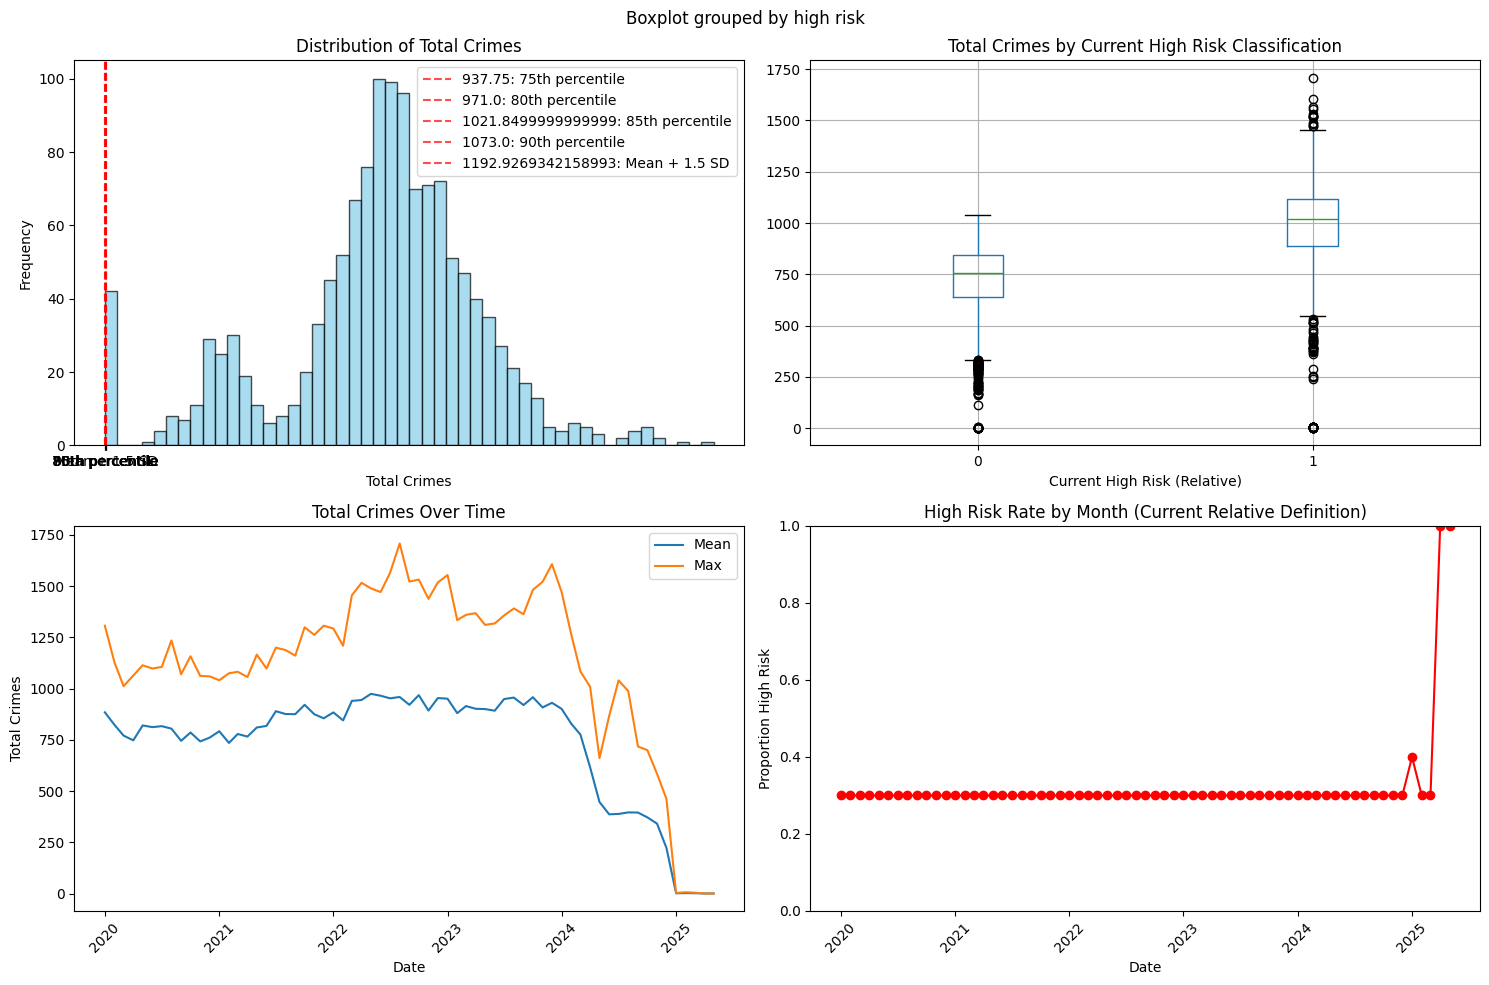


Comparison with old relative definition:
New (Absolute)     0    1   All
Old (Relative)                 
0                889   35   924
1                151  227   378
All             1040  262  1302

High risk rates by month:
            Relative_Rate  Absolute_Rate
date                                    
2020-01-01          0.286          0.190
2020-02-01          0.286          0.190
2020-03-01          0.286          0.048
2020-04-01          0.286          0.048
2020-05-01          0.286          0.143
...                   ...            ...
2025-01-01          0.429          0.000
2025-02-01          0.333          0.000
2025-03-01          0.300          0.000
2025-04-01          1.000          0.000
2025-05-01          1.000          0.000

[65 rows x 2 columns]

Overall high risk rates:
  Old (relative): 29.0%
  New (absolute): 20.1%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_crime_distribution(df):

    print(f"Total crime statistics:")
    print(f"  Mean: {df['total crimes'].mean():.1f}")
    print(f"  Median: {df['total crimes'].median():.1f}")
    print(f"  Std Dev: {df['total crimes'].std():.1f}")
    print(f"  Min: {df['total crimes'].min():.1f}")
    print(f"  Max: {df['total crimes'].max():.1f}")

    percentiles = [25, 50, 75, 80, 85, 90, 95, 99]
    print(f"\nPercentiles:")
    for p in percentiles:
        value = df['total crimes'].quantile(p/100)
        print(f"  {p}th percentile: {value:.1f}")

    current_high_risk_rate = df['high risk'].mean()
    print(f"\nCurrent high risk rate: {current_high_risk_rate:.1%}")

    print(f"\nHigh risk rate by month (with current relative definition):")
    monthly_rates = df.groupby('date')['high risk'].mean()
    print(monthly_rates)

    return df['total crimes'].describe()

def visualize_distribution(df, potential_thresholds=None):
    """Create visualizations to help choose the best absolute threshold"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].hist(df['total crimes'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Total Crimes')
    axes[0,0].set_xlabel('Total Crimes')
    axes[0,0].set_ylabel('Frequency')

    if potential_thresholds:
        for threshold, label in potential_thresholds.items():
            axes[0,0].axvline(threshold, color='red', linestyle='--', alpha=0.7, label=f'{label}: {threshold}')
        axes[0,0].legend()

    df.boxplot(column='total crimes', by='high risk', ax=axes[0,1])
    axes[0,1].set_title('Total Crimes by Current High Risk Classification')
    axes[0,1].set_xlabel('Current High Risk (Relative)')

    monthly_stats = df.groupby('date').agg({
        'total crimes': ['mean', 'max', 'min'],
        'high risk': 'mean'
    }).round(1)

    axes[1,0].plot(monthly_stats.index, monthly_stats[('total crimes', 'mean')], label='Mean')
    axes[1,0].plot(monthly_stats.index, monthly_stats[('total crimes', 'max')], label='Max')
    axes[1,0].set_title('Total Crimes Over Time')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Total Crimes')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)

    axes[1,1].plot(monthly_stats.index, monthly_stats[('high risk', 'mean')], marker='o', color='red')
    axes[1,1].set_title('High Risk Rate by Month (Current Relative Definition)')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Proportion High Risk')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def suggest_absolute_thresholds(df):

    overall_75th = df['total crimes'].quantile(0.75)
    overall_80th = df['total crimes'].quantile(0.80)
    overall_85th = df['total crimes'].quantile(0.85)
    overall_90th = df['total crimes'].quantile(0.90)

    print(f"  75th percentile: {overall_75th:.1f} (keeps ~25% as high risk)")
    print(f"  80th percentile: {overall_80th:.1f} (keeps ~20% as high risk)")
    print(f"  85th percentile: {overall_85th:.1f} (keeps ~15% as high risk)")
    print(f"  90th percentile: {overall_90th:.1f} (keeps ~10% as high risk)")

    mean = df['total crimes'].mean()
    std = df['total crimes'].std()
    stat_threshold_1std = mean + std
    stat_threshold_15std = mean + 1.5 * std
    stat_threshold_2std = mean + 2 * std

    print(f"  Mean + 1 SD: {stat_threshold_1std:.1f}")
    print(f"  Mean + 1.5 SD: {stat_threshold_15std:.1f}")
    print(f"  Mean + 2 SD: {stat_threshold_2std:.1f}")

    return {
        '75th percentile': overall_75th,
        '80th percentile': overall_80th,
        '85th percentile': overall_85th,
        '90th percentile': overall_90th,
        'Mean + 1.5 SD': stat_threshold_15std
    }

def apply_absolute_threshold(df, threshold, threshold_name="Custom"):

    df['high_risk_absolute'] = (df['total crimes'] >= threshold).astype(int)

    print(f"\nComparison with old relative definition:")
    comparison = pd.crosstab(df['high risk'], df['high_risk_absolute'],
                           rownames=['Old (Relative)'], colnames=['New (Absolute)'],
                           margins=True)
    print(comparison)

    print(f"\nHigh risk rates by month:")
    monthly_comparison = df.groupby('date').agg({
        'high risk': 'mean',
        'high_risk_absolute': 'mean'
    }).round(3)
    monthly_comparison.columns = ['Relative_Rate', 'Absolute_Rate']
    print(monthly_comparison)

    old_rate = df['high risk'].mean()
    new_rate = df['high_risk_absolute'].mean()
    print(f"\nOverall high risk rates:")
    print(f"  Old (relative): {old_rate:.1%}")
    print(f"  New (absolute): {new_rate:.1%}")

    return df

def convert_to_absolute_thresholds(df, chosen_threshold=None):

    # Step 1: Analyze current distribution
    stats = analyze_crime_distribution(df)

    # Step 2: Suggest thresholds
    suggested_thresholds = suggest_absolute_thresholds(df)

    # Step 3: Visualize to help decision
    visualize_distribution(df, suggested_thresholds)

    # Step 4: Apply threshold (default to 80th percentile if none chosen)
    if chosen_threshold is None:
        chosen_threshold = df['total crimes'].quantile(0.80)
        threshold_name = "80th Percentile (Default)"
    else:
        threshold_name = "Custom"

    df_updated = apply_absolute_threshold(df, chosen_threshold, threshold_name)

    return df_updated, chosen_threshold

df_updated, threshold = convert_to_absolute_thresholds(monthlyarea)


Created bins with edges: [0, 790.5, 866.5, 1039.5, inf]
Bin labels: ['Low', 'Medium-Low', 'Medium-High', 'High']

Bin distribution:
standalone_crimes_binned
Low            614
Medium-Low     208
Medium-High    307
High           173
Name: count, dtype: int64

Actual value ranges by bin:
Low: 1 - 790 (mean: 554, count: 614)
Medium-Low: 791 - 866 (mean: 825, count: 208)
Medium-High: 867 - 1039 (mean: 943, count: 307)
High: 1040 - 1708 (mean: 1175, count: 173)
Label encoding mapping:
  High -> 0
  Low -> 1
  Medium-High -> 2
  Medium-Low -> 3

Sample of original vs encoded:
   standalone crimes standalone_crimes_binned  standalone crimes encoded
0               1307                     High                          0
1               1104                     High                          0
2               1012              Medium-High                          2
3               1064                     High                          0
4               1077                     High            

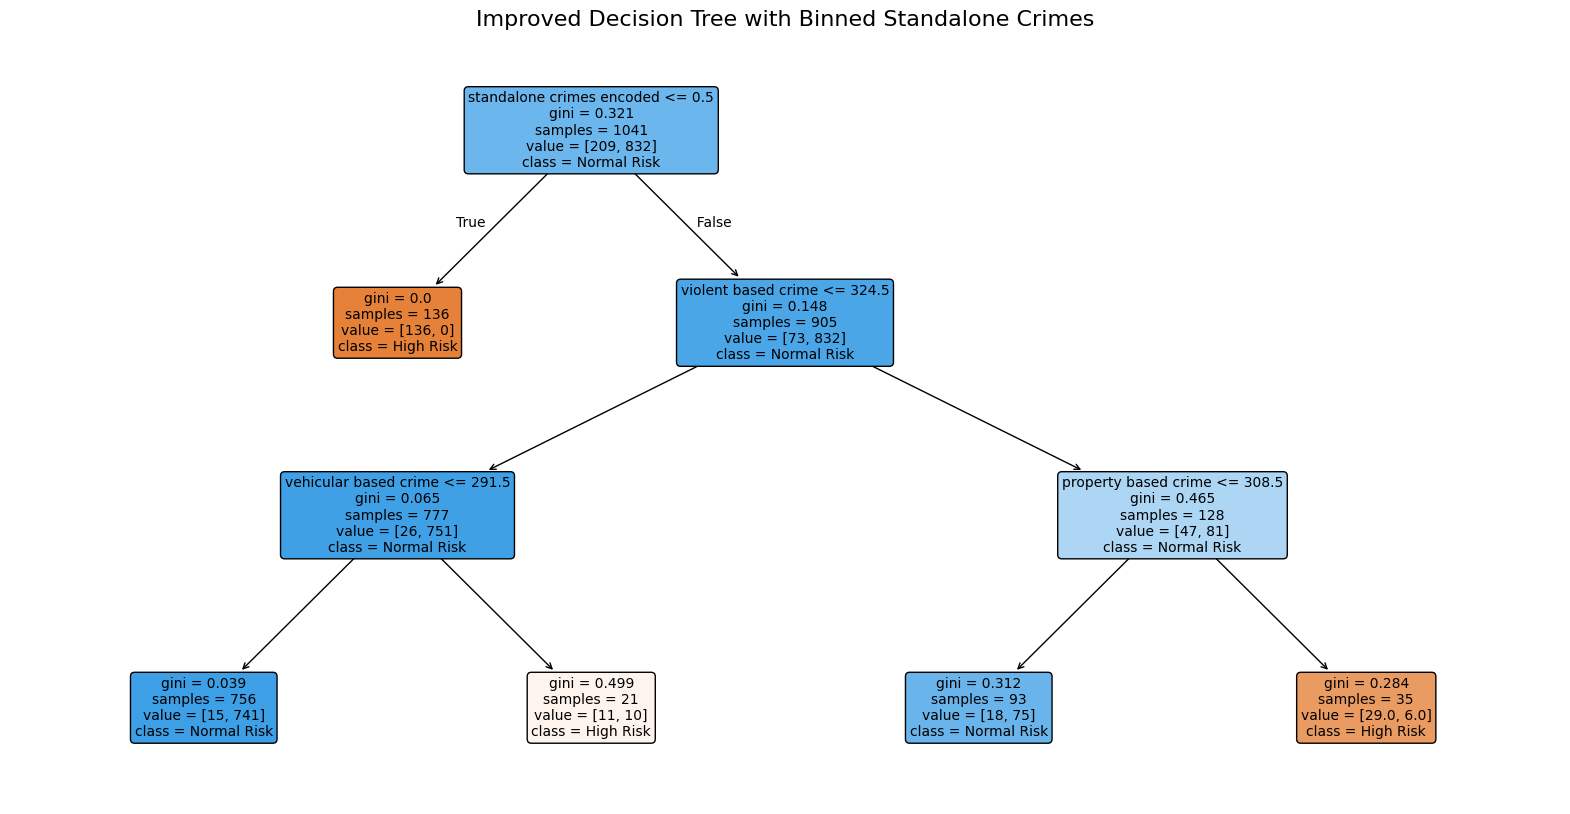

NameError: name 'le' is not defined

In [ ]:
from sklearn.tree import plot_tree

"""plt.figure(figsize=(20, 10))
plot_tree(decisionTree,
         feature_names= ['standalone crimes', 'vehicular based crime', 'violent based crime', 'property based crime', 'other crime'],
         class_names = ['Normal Risk', 'High Risk'],
         filled = True,
         max_depth = 2,
         fontsize = 8)
plt.title('Decision Tree for High Risk Area Prediction', fontsize = 16)
plt.show()"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

monthlyarea['high_risk_absolute'] = monthlyarea['high_risk_absolute'].map({0: 'Normal Risk', 1: 'High Risk'})

def create_tree_based_bins(df):

    bins = [0, 790.5, 866.5, 1039.5, float('inf')]
    labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

    df['standalone_crimes_binned'] = pd.cut(
        df['standalone crimes'],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    print(f"Created bins with edges: {bins}")
    print(f"Bin labels: {labels}")

    print("\nBin distribution:")
    bin_counts = df['standalone_crimes_binned'].value_counts().sort_index()
    print(bin_counts)

    print("\nActual value ranges by bin:")
    for label in labels:
        bin_data = df[df['standalone_crimes_binned'] == label]['standalone crimes']
        if len(bin_data) > 0:
            print(f"{label}: {bin_data.min():.0f} - {bin_data.max():.0f} "
                  f"(mean: {bin_data.mean():.0f}, count: {len(bin_data)})")

    return df

def apply_label_encoding(df):

    le = LabelEncoder()
    df['standalone crimes encoded'] = le.fit_transform(df['standalone_crimes_binned'])

    print("Label encoding mapping:")
    for i, label in enumerate(le.classes_):
        print(f"  {label} -> {i}")

    print("\nSample of original vs encoded:")
    sample = df[['standalone crimes', 'standalone_crimes_binned', 'standalone crimes encoded']].head(10)
    print(sample)

    return df, le

def prepare_features(df):
    feature_columns = [
        'standalone crimes encoded',
        'vehicular based crime',
        'violent based crime',
        'property based crime',
        'other crime'
    ]

    X = df[feature_columns].copy()

    print(f"Feature matrix shape: {X.shape}")
    print(f"Features: {feature_columns}")

    print("\nFeature summary:")
    print(X.describe())

    return X, feature_columns

def build_improved_tree(X, y, feature_names, max_depth=3):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )

    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)

    print(f"Training accuracy: {clf.score(X_train, y_train):.3f}")
    print(f"Testing accuracy: {clf.score(X_test, y_test):.3f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nFeature Importance:")
    for i, importance in enumerate(clf.feature_importances_):
        print(f"  {feature_names[i]}: {importance:.3f}")

    return clf, X_test, y_test, y_pred

def visualize_tree(clf, feature_names, class_names, figsize=(20, 10)):

    plt.figure(figsize=figsize)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title("Improved Decision Tree with Binned Standalone Crimes", fontsize=16)
    plt.show()

def interpret_tree_paths(clf, feature_names, class_names, le):

    tree = clf.tree_

    def print_decision_path(node, depth=0, condition="Root"):
        """Recursively print decision paths"""
        indent = "  " * depth

        if tree.feature[node] != -2:  # Not a leaf
            feature_name = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]

            if feature_name == 'standalone_crimes_encoded':
                threshold_category = le.classes_[int(threshold + 0.5)] if threshold + 0.5 < len(le.classes_) else "High"
                condition_left = f"standalone_crimes ≤ {threshold_category}"
                condition_right = f"standalone_crimes > {threshold_category}"
            else:
                condition_left = f"{feature_name} ≤ {threshold:.1f}"
                condition_right = f"{feature_name} > {threshold:.1f}"

            print(f"{indent}├─ {condition}")
            print(f"{indent}│  Samples: {tree.n_node_samples[node]}")

            # Left child (True condition)
            print_decision_path(tree.children_left[node], depth + 1, condition_left)

            # Right child (False condition)
            print_decision_path(tree.children_right[node], depth + 1, condition_right)

        else:  # Leaf node
            predicted_class = class_names[np.argmax(tree.value[node])]
            samples = tree.n_node_samples[node]
            confidence = np.max(tree.value[node]) / samples

            print(f"{indent}└─ PREDICTION: {predicted_class}")
            print(f"{indent}   Condition: {condition}")
            print(f"{indent}   Samples: {samples}")
            print(f"{indent}   Confidence: {confidence:.2f}")
            print()

    print_decision_path(0)

def complete_implementation(df, target_column, max_depth=3):
    print("=" * 60)

    # Step 1: Create bins
    df = create_tree_based_bins(df)

    # Step 2: Apply encoding
    df, label_encoder = apply_label_encoding(df)

    # Step 3: Prepare features
    X, feature_names = prepare_features(df)

    # Get target variable
    y = df[target_column]
    class_names = sorted(y.unique())

    print(f"\nTarget variable: {target_column}")
    print(f"Classes: {class_names}")
    print(f"Class distribution:\n{y.value_counts()}")

    # Step 4: Build tree
    clf, X_test, y_test, y_pred = build_improved_tree(X, y, feature_names, max_depth)

    # Step 5: Visualize
    visualize_tree(clf, feature_names, class_names)

    # Step 6: Interpret
    interpret_tree_paths(clf, feature_names, class_names, le)

    return df, clf, le

monthlyarea, decisionTree, le = complete_implementation(
    df=monthlyarea,
    target_column='high_risk_absolute',
    max_depth=3
)

OK, OK, this is the explanation of the tree. Now, ignore all the graphs above the tree-- that's AI. Mostly. I did use some of that. But the tree, that was mostly me and a little AI because the graph stuff. Graphs: we don't care. Tree? We DO care.

This tree shows that areas that have low standalone crimes that still hit the threshold are 100% high risk. Meaning those areas have concentrated crimes (violent, vehicular, property, or otherwise) and so those areas are way more dangerous than areas with lots of standalone crimes of a petty nature. The crimes in these areas are serious. That's the left branch. In other words, we have proven that if a crime escalates, it's pretty serious.

In the right branch, you can see that there are lots of normal risk areas. This shows that these areas have lots of minor standalone incidents, but they don't cross the total crime threshold.

Now, what's important to note is that, if you look at the code for this lovely tree, you won't see "area" used at all. Why? I left this tree without area data because the crime patterns should be consistent across geography-- that is, I have been running the EDA for spatial and failing, so I can't know for certain right now if there's any differences in where crime takes place. But I can contribute from each area equally to my training data, then see if the low standalone crime = high risk observation is true.

A challenge that we might run across because of this is that if an area is underrepresented in the data, my tree... falls apart. It's not balanced that way. Some areas may need different thresholds too-- I mean, there's problems with this approach. I could check to see if there's good representation in the data across all the police areas, but time and my knowledge are running short on that regard. What I think could happen is that if the low standalone = high risk observation only appears in a few areas, then we don't really hve a crime pattern detector... more like... a location detector (very complex for no reason, too) so it won't generalize to any areas that have different patterns. If different areas look drastically different from one another, like, one area is more likely to have vehicular crime, and one has more violent crime, but one has more property crime, then the tree isn't capturing those patterns at all. Also, if there's an imbalance in the data-- like 90% of the crimes are from Hollywood, then the tree only learns about crime in Hollywood, essentially. However, I don't know how to effectively account for all of these at once without also ruining the tree... It is an issue. That's why I picked to go general. I think if we were to do this again, the EDA into spatial would need to be a lot more robust-- I didn't have the time to do this **specific** test, but I feel like had I known this was going to be the outcome, I might've checked to see how the reported crimes were distributed by area, etc.

In [ ]:
from sklearn.preprocessing import StandardScaler

lapd_plus_zip['Total Population'] = pd.to_numeric(lapd_plus_zip['Total Population'].str.replace(',', ''), errors='coerce')
lapd_plus_zip['Total Males'] = pd.to_numeric(lapd_plus_zip['Total Males'].str.replace(',', ''), errors='coerce')
lapd_plus_zip['Total Females'] = pd.to_numeric(lapd_plus_zip['Total Females'].str.replace(',', ''), errors='coerce')

lapd_plus_zip['male ratio'] = lapd_plus_zip['Total Males'] / lapd_plus_zip['Total Population']
lapd_plus_zip['female ratio'] = lapd_plus_zip['Total Females'] / lapd_plus_zip['Total Population']

demo_columns = ['Total Population', 'Median Age', 'male ratio', 'female ratio', 'Average Household Size']
scaler = StandardScaler()
lapd_plus_zip[['Pop Scaled', 'Age Scaled', 'Male Ratio Scaled', 'Female Ratio Scaled', 'Household Scaled']] = scaler.fit_transform(lapd_plus_zip[demo_columns])

areadummies = pd.get_dummies(lapd_plus_zip['AREA'], prefix='area')
areacols = areadummies.columns[1:]

In [ ]:
areasumm_vehicle = lapd_plus_zip.groupby('AREA')['vehicular based crime'].agg(['count', 'sum', 'mean']).round(3)
areasumm_violent = lapd_plus_zip.groupby('AREA')['violent based crime'].agg(['count', 'sum', 'mean']).round(3)
areasumm_property = lapd_plus_zip.groupby('AREA')['property based crime'].agg(['count', 'sum', 'mean']).round(3)
areasumm_other = lapd_plus_zip.groupby('AREA')['other crime'].agg(['count', 'sum', 'mean']).round(3)

areasumm_vehicle.columns = ['Total Incidents', 'Vehicle Crime', 'Vehicle Crime Rate']
print("Vehicle Crime Summary by Area:")
print(areasumm_vehicle.sort_values(by='Vehicle Crime Rate', ascending=False))

areasumm_violent.columns = ['Total Incidents', 'Violent Crime', 'Violent Crime Rate']
print("\nViolent Crime Summary by Area:")
print(areasumm_violent.sort_values(by='Violent Crime Rate', ascending=False))

areasumm_property.columns = ['Total Incidents', 'Property Crime', 'Property Crime Rate']
print("\nProperty Crime Summary by Area:")
print(areasumm_property.sort_values(by='Property Crime Rate', ascending=False))

areasumm_other.columns = ['Total Incidents', 'Other Crime', 'Other Crime Rate']
print("\nOther Crime Summary by Area:")
print(areasumm_other.sort_values(by='Other Crime Rate', ascending=False))

Vehicle Crime Summary by Area:
      Total Incidents  Vehicle Crime  Vehicle Crime Rate
AREA                                                    
11              42963          14082               0.328
14              59514          19431               0.326
4               37085          11142               0.300
19              40351          12044               0.298
13              49177          14477               0.294
15              51107          14659               0.287
9               42883          12135               0.283
5               41394          11676               0.282
16              33133           9289               0.280
10              42156          11672               0.277
17              41756          11430               0.274
20              50071          13710               0.274
8               45729          12463               0.273
1               69670          18943               0.272
3               57441          15207               0.265


Optimization terminated successfully.
         Current function value: 0.583921
         Iterations 5
                             Logit Regression Results                            
Dep. Variable:     vehicular based crime   No. Observations:               983172
Model:                             Logit   Df Residuals:                   983147
Method:                              MLE   Df Model:                           24
Date:                   Sun, 28 Sep 2025   Pseudo R-squ.:                0.003606
Time:                           23:26:42   Log-Likelihood:            -5.7409e+05
converged:                          True   LL-Null:                   -5.7617e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.1722      0.012   -101.087      0.000   

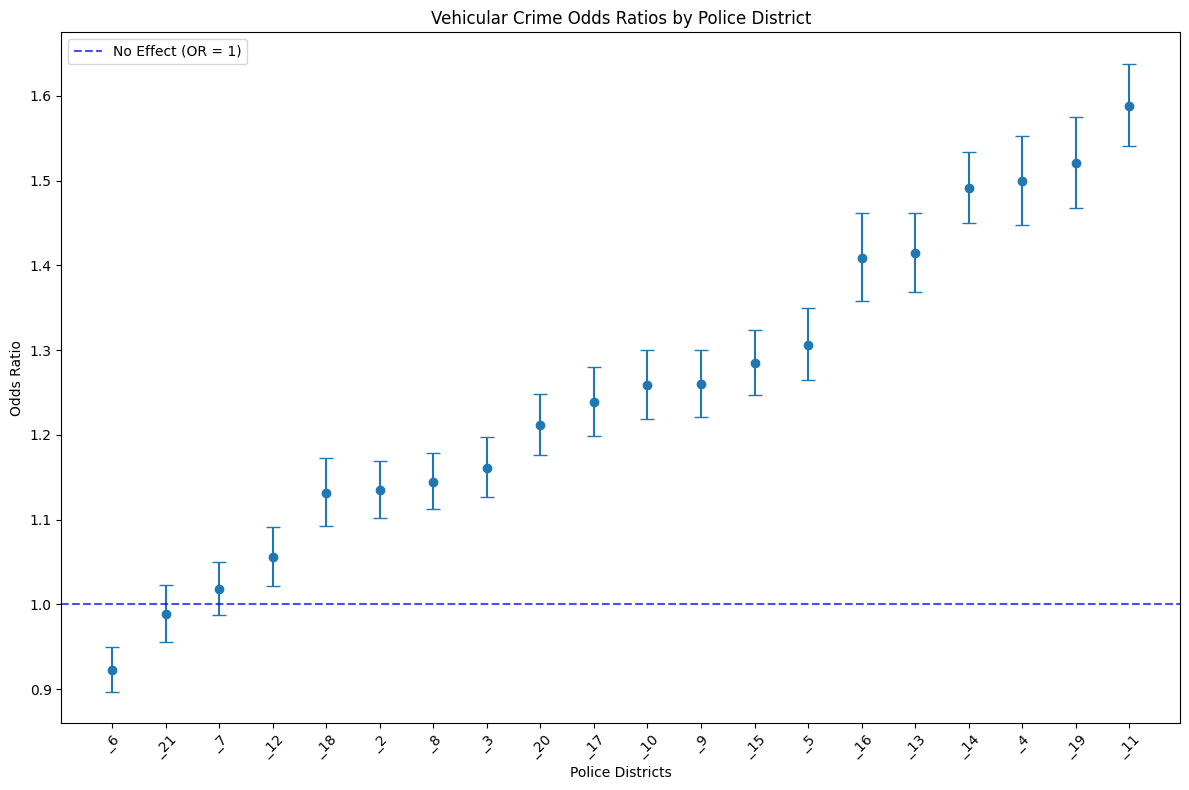

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['Pop Scaled', 'Age Scaled', 'Male Ratio Scaled', 'Female Ratio Scaled', 'Household Scaled']

X = pd.concat([
    lapd_plus_zip[features],
    areadummies[areacols]
], axis=1)

y = lapd_plus_zip['vehicular based crime']

# Convert boolean columns in X to integers
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Ensure all columns are numeric, coercing errors
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


mask = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask]
y_clean = y[mask]

# Drop rows where vehicular_based_crime is NaN after filtering X
# This handles cases where the target variable might have NaNs not aligned with X NaNs
mask_y = ~y_clean.isnull()
X_clean = X_clean[mask_y]
y_clean = y_clean[mask_y]

XwithIntercept = sm.add_constant(X_clean)

# Ensure y_clean is numeric before passing to Logit
y_clean = pd.to_numeric(y_clean, errors='coerce')
# Drop rows with NaNs in y_clean after coercion, just in case
nan_y_mask = ~y_clean.isnull()
XwithIntercept = XwithIntercept[nan_y_mask]
y_clean = y_clean[nan_y_mask]


# Check if there are still data points left
if XwithIntercept.empty or y_clean.empty:
    print("Error: No valid data points left after cleaning.")
else:
    model = sm.Logit(y_clean, XwithIntercept)
    result = model.fit()
    print(result.summary())

odds_ratios = np.exp(result.params)

conf_int = np.exp(result.conf_int())

conf_int.columns = ['OR Lower', 'OR Upper']

results = pd.DataFrame({
    'coefficient': result.params,
    'p value': result.pvalues,
    'odds ratio': odds_ratios,
    '95% OR Lower': conf_int['OR Lower'],
    '95% OR Upper': conf_int['OR Upper']
})

arearesults = results[results.index.str.startswith('area')]
print(f"District Effects (vs Reference District): {arearesults.round(3)}")

sigareas = arearesults[arearesults['p value'] < 0.05]
print(f"Districts with significantly different vehicular crime rates: {sigareas.round(3)}")

plt.figure(figsize=(12,8))
areasorted = arearesults.sort_values('odds ratio')

plt.errorbar(range(len(areasorted)),
             areasorted['odds ratio'],
             yerr=[areasorted['odds ratio'] - areasorted['95% OR Lower'],
                   areasorted['95% OR Upper'] - areasorted['odds ratio']],
             fmt='o', capsize = 5)

plt.axhline(y=1,
            color = 'blue',
            linestyle = '--',
            alpha = 0.7,
            label = "No Effect (OR = 1)")

plt.xticks(range(len(areasorted)),
           areasorted.index.str.replace('area', ''),
           rotation = 45)

plt.ylabel('Odds Ratio')
plt.xlabel('Police Districts')
plt.title("Vehicular Crime Odds Ratios by Police District")
plt.legend()
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.595531
         Iterations 13
                            Logit Regression Results                           
Dep. Variable:     violent based crime   No. Observations:               983172
Model:                           Logit   Df Residuals:                   983147
Method:                            MLE   Df Model:                           24
Date:                 Sun, 28 Sep 2025   Pseudo R-squ.:                 0.02273
Time:                         23:32:02   Log-Likelihood:            -5.8551e+05
converged:                        True   LL-Null:                   -5.9913e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5080        nan        nan        nan         nan      

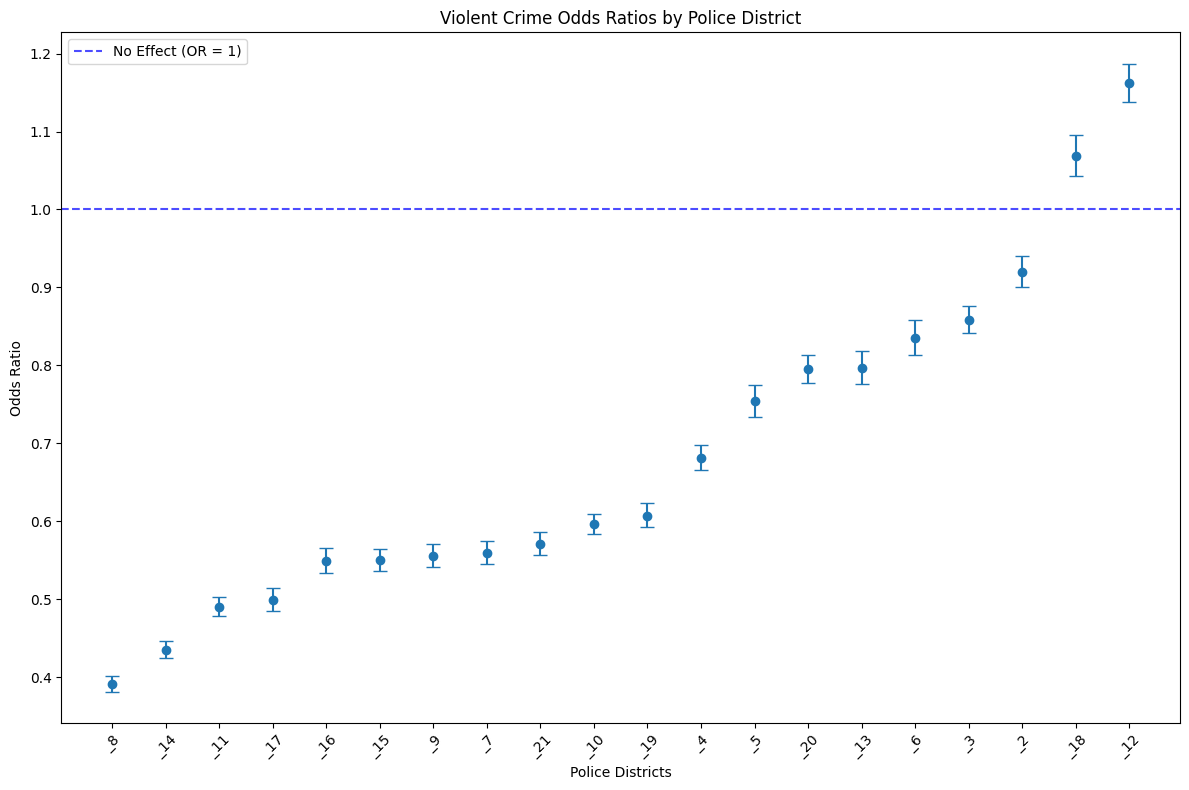

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['Pop Scaled', 'Age Scaled', 'Male Ratio Scaled', 'Female Ratio Scaled', 'Household Scaled']

X = pd.concat([
    lapd_plus_zip[features],
    areadummies[areacols]
], axis=1)

y = lapd_plus_zip['violent based crime']

# Convert boolean columns in X to integers
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Ensure all columns are numeric, coercing errors
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


mask = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask]
y_clean = y[mask]

# Drop rows where vehicular_based_crime is NaN after filtering X
# This handles cases where the target variable might have NaNs not aligned with X NaNs
mask_y = ~y_clean.isnull()
X_clean = X_clean[mask_y]
y_clean = y_clean[mask_y]

XwithIntercept = sm.add_constant(X_clean)

# Ensure y_clean is numeric before passing to Logit
y_clean = pd.to_numeric(y_clean, errors='coerce')
# Drop rows with NaNs in y_clean after coercion, just in case
nan_y_mask = ~y_clean.isnull()
XwithIntercept = XwithIntercept[nan_y_mask]
y_clean = y_clean[nan_y_mask]


# Check if there are still data points left
if XwithIntercept.empty or y_clean.empty:
    print("Error: No valid data points left after cleaning.")
else:
    model = sm.Logit(y_clean, XwithIntercept)
    result = model.fit()
    print(result.summary())

odds_ratios = np.exp(result.params)

conf_int = np.exp(result.conf_int())

conf_int.columns = ['OR Lower', 'OR Upper']

results = pd.DataFrame({
    'coefficient': result.params,
    'p value': result.pvalues,
    'odds ratio': odds_ratios,
    '95% OR Lower': conf_int['OR Lower'],
    '95% OR Upper': conf_int['OR Upper']
})

arearesults = results[results.index.str.startswith('area')]
print(f"District Effects (vs Reference District): {arearesults.round(3)}")

sigareas = arearesults[arearesults['p value'] < 0.05]
print(f"Districts with significantly different violent crime rates: {sigareas.round(3)}")

plt.figure(figsize=(12,8))
areasorted = arearesults.sort_values('odds ratio')

plt.errorbar(range(len(areasorted)),
             areasorted['odds ratio'],
             yerr=[areasorted['odds ratio'] - areasorted['95% OR Lower'],
                   areasorted['95% OR Upper'] - areasorted['odds ratio']],
             fmt='o', capsize = 5)

plt.axhline(y=1,
            color = 'blue',
            linestyle = '--',
            alpha = 0.7,
            label = "No Effect (OR = 1)")

plt.xticks(range(len(areasorted)),
           areasorted.index.str.replace('area', ''),
           rotation = 45)

plt.ylabel('Odds Ratio')
plt.xlabel('Police Districts')
plt.title("Violent Crime Odds Ratios by Police District")
plt.legend()
plt.tight_layout()
plt.show()

         Current function value: 0.645241
         Iterations: 35


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            Logit Regression Results                            
Dep. Variable:     property based crime   No. Observations:               983172
Model:                            Logit   Df Residuals:                   983147
Method:                             MLE   Df Model:                           24
Date:                  Sun, 28 Sep 2025   Pseudo R-squ.:                 0.01331
Time:                          23:33:49   Log-Likelihood:            -6.3438e+05
converged:                        False   LL-Null:                   -6.4294e+05
Covariance Type:              nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8031      0.011    -74.622      0.000      -0.824      -0.782
Pop Scaled             -0.0491      0.003    -14.334      0.000      -0.056      -0.042


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


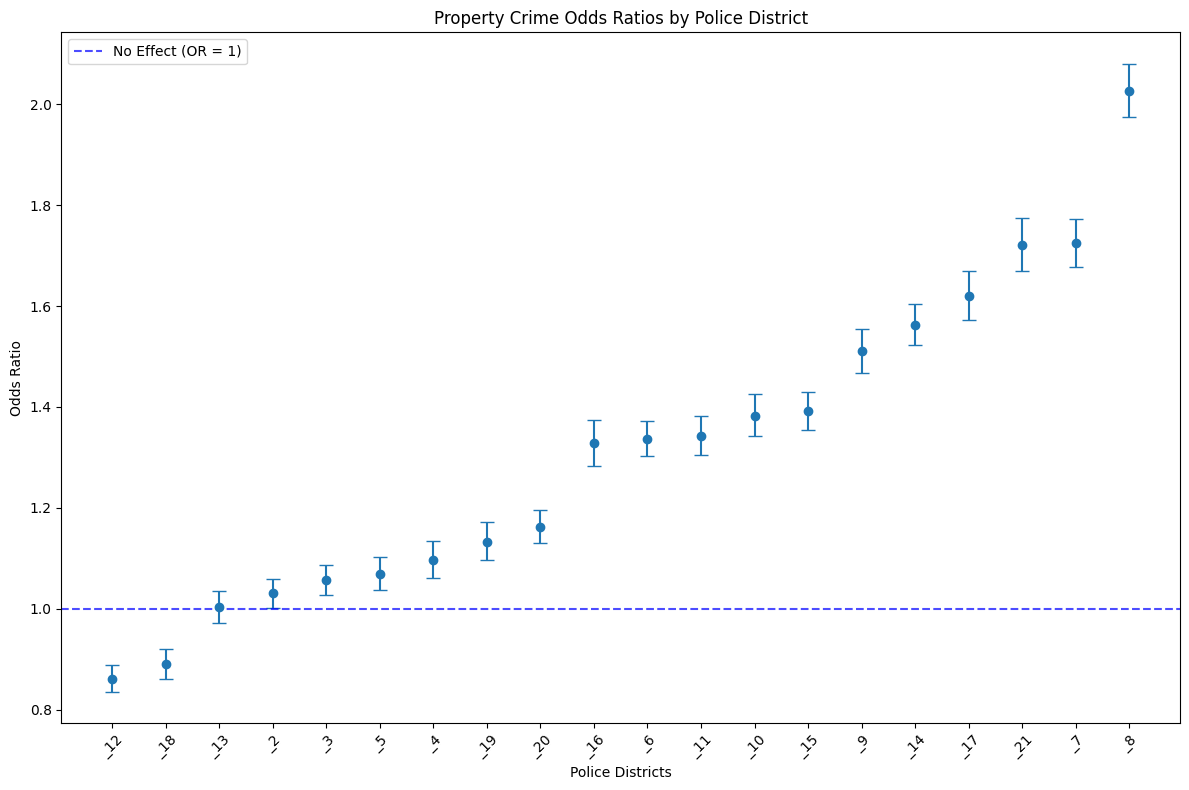

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['Pop Scaled', 'Age Scaled', 'Male Ratio Scaled', 'Female Ratio Scaled', 'Household Scaled']

X = pd.concat([
    lapd_plus_zip[features],
    areadummies[areacols]
], axis=1)

y = lapd_plus_zip['property based crime']


for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


mask = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask]
y_clean = y[mask]

mask_y = ~y_clean.isnull()
X_clean = X_clean[mask_y]
y_clean = y_clean[mask_y]

XwithIntercept = sm.add_constant(X_clean)


y_clean = pd.to_numeric(y_clean, errors='coerce')

nan_y_mask = ~y_clean.isnull()
XwithIntercept = XwithIntercept[nan_y_mask]
y_clean = y_clean[nan_y_mask]

if XwithIntercept.empty or y_clean.empty:
    print("Error: No valid data points left after cleaning.")
else:
    model = sm.Logit(y_clean, XwithIntercept)
    result = model.fit()
    print(result.summary())

odds_ratios = np.exp(result.params)

conf_int = np.exp(result.conf_int())

conf_int.columns = ['OR Lower', 'OR Upper']

results = pd.DataFrame({
    'coefficient': result.params,
    'p value': result.pvalues,
    'odds ratio': odds_ratios,
    '95% OR Lower': conf_int['OR Lower'],
    '95% OR Upper': conf_int['OR Upper']
})

arearesults = results[results.index.str.startswith('area')]
print(f"District Effects (vs Reference District): {arearesults.round(3)}")

sigareas = arearesults[arearesults['p value'] < 0.05]
print(f"Districts with significantly different property crime rates: {sigareas.round(3)}")

plt.figure(figsize=(12,8))
areasorted = arearesults.sort_values('odds ratio')

plt.errorbar(range(len(areasorted)),
             areasorted['odds ratio'],
             yerr=[areasorted['odds ratio'] - areasorted['95% OR Lower'],
                   areasorted['95% OR Upper'] - areasorted['odds ratio']],
             fmt='o', capsize = 5)

plt.axhline(y=1,
            color = 'blue',
            linestyle = '--',
            alpha = 0.7,
            label = "No Effect (OR = 1)")

plt.xticks(range(len(areasorted)),
           areasorted.index.str.replace('area', ''),
           rotation = 45)

plt.ylabel('Odds Ratio')
plt.xlabel('Police Districts')
plt.title("Property Crime Odds Ratios by Police District")
plt.legend()
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.247803
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:            other crime   No. Observations:               983172
Model:                          Logit   Df Residuals:                   983147
Method:                           MLE   Df Model:                           24
Date:                Sun, 28 Sep 2025   Pseudo R-squ.:                0.002665
Time:                        23:35:02   Log-Likelihood:            -2.4363e+05
converged:                       True   LL-Null:                   -2.4428e+05
Covariance Type:            nonrobust   LLR p-value:                4.678e-260
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4234      0.019   -126.666      0.000      -2.461      -2.386
P

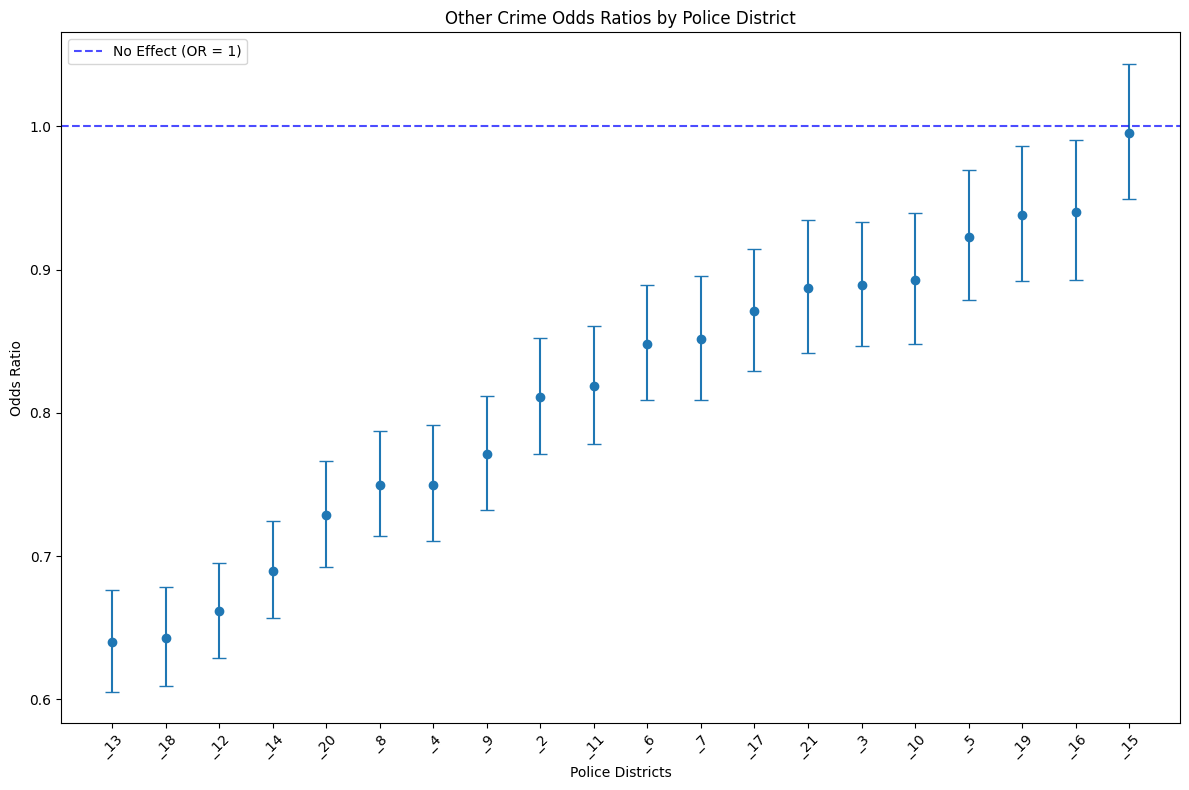

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['Pop Scaled', 'Age Scaled', 'Male Ratio Scaled', 'Female Ratio Scaled', 'Household Scaled']

X = pd.concat([
    lapd_plus_zip[features],
    areadummies[areacols]
], axis=1)

y = lapd_plus_zip['other crime']


for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')


mask = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask]
y_clean = y[mask]

mask_y = ~y_clean.isnull()
X_clean = X_clean[mask_y]
y_clean = y_clean[mask_y]

XwithIntercept = sm.add_constant(X_clean)


y_clean = pd.to_numeric(y_clean, errors='coerce')

nan_y_mask = ~y_clean.isnull()
XwithIntercept = XwithIntercept[nan_y_mask]
y_clean = y_clean[nan_y_mask]

if XwithIntercept.empty or y_clean.empty:
    print("Error: No valid data points left after cleaning.")
else:
    model = sm.Logit(y_clean, XwithIntercept)
    result = model.fit()
    print(result.summary())

odds_ratios = np.exp(result.params)

conf_int = np.exp(result.conf_int())

conf_int.columns = ['OR Lower', 'OR Upper']

results = pd.DataFrame({
    'coefficient': result.params,
    'p value': result.pvalues,
    'odds ratio': odds_ratios,
    '95% OR Lower': conf_int['OR Lower'],
    '95% OR Upper': conf_int['OR Upper']
})

arearesults = results[results.index.str.startswith('area')]
print(f"District Effects (vs Reference District): {arearesults.round(3)}")

sigareas = arearesults[arearesults['p value'] < 0.05]
print(f"Districts with significantly different other crime rates: {sigareas.round(3)}")

plt.figure(figsize=(12,8))
areasorted = arearesults.sort_values('odds ratio')

plt.errorbar(range(len(areasorted)),
             areasorted['odds ratio'],
             yerr=[areasorted['odds ratio'] - areasorted['95% OR Lower'],
                   areasorted['95% OR Upper'] - areasorted['odds ratio']],
             fmt='o', capsize = 5)

plt.axhline(y=1,
            color = 'blue',
            linestyle = '--',
            alpha = 0.7,
            label = "No Effect (OR = 1)")

plt.xticks(range(len(areasorted)),
           areasorted.index.str.replace('area', ''),
           rotation = 45)

plt.ylabel('Odds Ratio')
plt.xlabel('Police Districts')
plt.title("Other Crime Odds Ratios by Police District")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
areamapnames = lapd_plus_zip[['AREA', 'AREA NAME']].drop_duplicates().sort_values('AREA')

mapping_area = areamapnames.copy()
mapping_area.columns = ['District Number', 'District Name']
mapping_area = mapping_area.reset_index(drop=True)

print(f"\n\nTotal Districts: {len(mapping_area)}")
print(f"\n\nDistrict Mapping Table:")
print(mapping_area.to_string(index=False))



Total Districts: 21


District Mapping Table:
 District Number District Name
               1       Central
               2       Rampart
               3     Southwest
               4    Hollenbeck
               5        Harbor
               6     Hollywood
               7      Wilshire
               8       West LA
               9      Van Nuys
              10   West Valley
              11     Northeast
              12   77th Street
              13        Newton
              14       Pacific
              15   N Hollywood
              16      Foothill
              17    Devonshire
              18     Southeast
              19       Mission
              20       Olympic
              21       Topanga
